# Imports and dataset download

In [1]:
import csv
import torch 
import sklearn
import scipy
from scipy import io
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataset import Dataset
import matplotlib.pyplot as plt
from torchvision import datasets
import torch.utils.data as data
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.metrics.cluster import normalized_mutual_info_score, adjusted_rand_score
from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from tqdm.notebook import trange, tqdm
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from scipy.optimize import linear_sum_assignment as linear_assignment
from typing import Optional
import seaborn as sns

import copy
import random
import time
from math import floor

import os


In [2]:
def get_10x_73k_np(data_points=-1):
	# Original Labels are within 0 to 9.
	# But proper label mapping is required as there are 8 classes.
	map_labels = {0: 0, 1: 1, 2: 2, 4: 3, 6: 4, 7: 5, 8: 6, 9: 7}
	notebook_path = os.path.abspath("10x_73k-clustering.ipynb")
	labels_path = os.path.join(os.path.dirname(notebook_path), "drive/MyDrive/Diploma/labels.txt")
	data_path = os.path.join(os.path.dirname(notebook_path),"drive/MyDrive/Diploma/sub_set-720.mtx")

	# Read data
	data = scipy.io.mmread(data_path)
	data = data.toarray()
	data = np.log2(data + 1)
	scale = np.max(data)
	data = data / scale
	total_size = data.shape[0]
	random_permutation = np.random.permutation(np.arange(total_size))
	data = data[random_permutation]

	# Read labels
	labels = np.loadtxt(labels_path).astype(int)
	labels = labels[random_permutation]
	labels = np.array([map_labels[i] for i in labels])

	if (data_points > 0):
		data = data[:data_points]
		labels = labels[:data_points]

	return data, labels

In [3]:
our_data, our_labels = get_10x_73k_np(10000)

In [4]:
cluster_counters = {i : 0 for i in range(8)}

for label in our_labels:
    cluster_counters[label] += 1

print(cluster_counters)

{0: 1303, 1: 367, 2: 1355, 3: 1164, 4: 1382, 5: 1607, 6: 1474, 7: 1348}


# MLP/Custom dataset/function declarations

In [5]:
class CustomDataset(Dataset):
  def __init__(self, datapoints, labels, transform=None):

    self.datapoints = datapoints
    self.labels = labels
    self.transform = transform

  def __getitem__(self, index):
    sample = self.datapoints[index], self.labels[index]

    if self.transform:
      sample = self.transform(sample)

    return sample
  
  def __len__(self):
    return len(self.datapoints)

In [6]:
# TODO: search hungarian algorithm
def cluster_accuracy(y_true, y_predicted, cluster_number: Optional[int] = None):
	"""
	Calculate clustering accuracy after using the linear_sum_assignment function in SciPy to
	determine reassignments.

	:param y_true: list of true cluster numbers, an integer array 0-indexed
	:param y_predicted: list of predicted cluster numbers, an integer array 0-indexed
	:param cluster_number: number of clusters, if None then calculated from input
	:return: reassignment dictionary, clustering accuracy
	"""
	if cluster_number is None:
		# assume labels are 0-indexed
		cluster_number = (max(y_predicted.max(), y_true.max()) + 1)
	count_matrix = np.zeros((cluster_number, cluster_number), dtype=np.int64)
	for i in range(y_predicted.size):
		count_matrix[y_predicted[i], y_true[i]] += 1

	row_ind, col_ind = linear_assignment(count_matrix.max() - count_matrix)
	reassignment = dict(zip(row_ind, col_ind))
	accuracy = count_matrix[row_ind, col_ind].sum() / y_predicted.size
	return reassignment, accuracy

def transform_clusters_to_labels(clusters, labels):
	# Find the cluster ids (labels)
	c_ids = np.unique(clusters)

	# Dictionary to transform cluster label to real label
	dict_clusters_to_labels = dict()

	# For every cluster find the most frequent data label
	for c_id in c_ids:
		indexes_of_cluster_i = np.where(c_id == clusters)
		elements, frequency = np.unique(labels[indexes_of_cluster_i], return_counts=True)
		true_label_index = np.argmax(frequency)
		true_label = elements[true_label_index]
		dict_clusters_to_labels[c_id] = true_label

	# Change the cluster labels to real labels
	for i, element in enumerate(clusters):
		clusters[i] = dict_clusters_to_labels[element]

	return clusters



In [7]:
def check_number_of_representatives(Y): # TODO: check for empty clusters
  cluster_map = {}

  for element in Y:
    if element not in cluster_map:
      cluster_map[element] = 1
    else:
      cluster_map[element] += 1

  for cluster_number in cluster_map.keys():
    print("Cluster", cluster_number, ":", cluster_map[cluster_number], "elements \n")

In [8]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hl1_neurons, hl2_neurons):
        super().__init__()

        self.model_0 = nn.Sequential(
          nn.Linear(input_dim, hl1_neurons),
          nn.LeakyReLU(0.2, inplace=True), # search ReLU ** 2
          nn.BatchNorm1d(hl1_neurons),

          nn.Linear(hl1_neurons, hl2_neurons),
          nn.LeakyReLU(0.2, inplace=True),
          nn.BatchNorm1d(hl2_neurons),
        )

        self.model_1 = nn.Sequential(
          nn.Linear(hl2_neurons, output_dim),
          nn.LeakyReLU(0.2, inplace=True)
        )

        self.model = nn.Sequential(
          self.model_0,
          self.model_1
        )
        
        # self.input_fc = nn.Linear(input_dim, hl1_neurons) # means we're getting input_dim inputs and connecting to 250 neurons on the next level
        # self.hidden_fc = nn.Linear(hl1_neurons, hl2_neurons) # HL1: we have 250 hidden neurons that connect to 100 neurons in the next level
        # self.output_fc = nn.Linear(hl2_neurons, output_dim) # HL2: we have 100 hidden neurons that connect to output_dim outputs

    def forward(self, x):
      x = self.model(x)
      x = F.softmax(x, dim=1)
      return x
  
    def get_hidden_representations(self, x):
      return self.model_0(x)

    # def forward(self, x):

    #     # x = [batch size, height, width]

    #     batch_size = x.shape[0]

    #     x = x.view(batch_size, -1)

    #     # x = [batch size, height * width]

    #     h_1 = F.relu(self.input_fc(x))

    #     # h_1 = [batch size, 250]

    #     h_2 = F.relu(self.hidden_fc(h_1))

    #     # h_2 = [batch size, 100]

    #     y_pred = self.output_fc(h_2)

    #     # y_pred = [batch size, output dim]

    #     return y_pred, h_2

In [9]:
class MLP_module():
    def __init__(self, input_dim, output_dim, train_dataset, test_dataset, valid_ratio, hl1_neurons, hl2_neurons, number_of_epochs=10):
        
        self.validation_ratio = valid_ratio
        self.model = MLP(input_dim, output_dim, hl1_neurons, hl2_neurons)
        self.input_dimensions = input_dim
        self.output_dimensions = output_dim
        self.hl1_neurons = hl1_neurons
        self.hl2_neurons = hl2_neurons

        # self.ROOT = '.data'
        self.PATH = ".MLP_model.pth"
        self.train_data = train_dataset
        self.test_data = test_dataset
        self.number_of_epochs = number_of_epochs
        
    def count_parameters(self):
      return sum(p.numel() for p in self.model.parameters() if p.requires_grad)

    def get_hidden_representations(self, x):
      return self.model.get_hidden_representations(x)

    def forward(self, x):
      return self.model(x)

    def create_validation_set(self):

      # Creating a validation set, which will help fend off overtraining.

      VALID_RATIO = self.validation_ratio

      n_train_examples = int(len(self.train_data) * VALID_RATIO)
      n_valid_examples = len(self.train_data) - n_train_examples

      self.train_data, self.valid_data = data.random_split(self.train_data, [n_train_examples, n_valid_examples])

      # print(f'Number of training examples: {len(self.train_data)}')
      # print(f'Number of validation examples: {len(self.valid_data)}')
      # print(f'Number of testing examples: {len(self.test_data)}')

    def transform_validation_set(self):

      # We need to transform validation data (to a tensor) as well. We need to make sure that we first make a deepcopy, since
      # it is a subset of the original train data.

      self.valid_data = copy.deepcopy(self.valid_data)
      self.valid_data.dataset.transform = self.test_transforms

    # Next, we'll define a DataLoader for each of the training/validation/test sets.
    # We can iterate over these, and they will yield batches of images and labels which we can use to train our model.

    # We only need to shuffle our training set as it will be used for stochastic gradient descent,
    # and we want each batch to be different between epochs. As we aren't using the validation or test sets
    # to update our model parameters, they do not need to be shuffled.

    # Ideally, we want to use the biggest batch size that we can. The 64 here is relatively small and can be
    # increased if our hardware can handle it.

    def define_dataLoaders(self):

      BATCH_SIZE = 64

      self.train_iterator = data.DataLoader(self.train_data,
                                      shuffle=True,
                                      batch_size=BATCH_SIZE)

      self.valid_iterator = data.DataLoader(self.valid_data,
                                      batch_size=BATCH_SIZE)

      self.test_iterator = data.DataLoader(self.test_data,
                                      batch_size=BATCH_SIZE)
      
    def count_parameters(model):
      return sum(p.numel() for p in model.parameters() if p.requires_grad)

    def set_parameters(self):
      self.optimizer = optim.Adam(self.model.parameters())
      self.criterion = nn.CrossEntropyLoss()
      self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
      self.model = self.model.to(self.device)
      self.criterion = self.criterion.to(self.device)

    def calculate_accuracy(self, y_pred, y):
      top_pred = y_pred.argmax(1, keepdim=True) 
      correct = top_pred.eq(y.view_as(top_pred)).sum()
      acc = correct.float() / y.shape[0]
      return acc

    def train(self, iterator):

      epoch_loss = 0
      epoch_acc = 0

      self.model = self.model.double()
      self.model.train()

      for (x, y) in tqdm(iterator, desc="Training", leave=False):

          x = x.to(self.device)
          y = y.to(self.device)

          self.optimizer.zero_grad()

          y_pred = self.model(x)

          loss = self.criterion(y_pred, y)

          acc = self.calculate_accuracy(y_pred, y)

          loss.backward()

          self.optimizer.step()

          epoch_loss += loss.item()
          epoch_acc += acc.item()

      return epoch_loss / len(iterator), epoch_acc / len(iterator)

    def evaluate(self, iterator):

      epoch_loss = 0
      epoch_acc = 0

      self.model.eval()

      with torch.no_grad():

          for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

              x = x.to(self.device)
              y = y.to(self.device)

              y_pred = self.model(x)

              loss = self.criterion(y_pred, y)

              acc = self.calculate_accuracy(y_pred, y)

              epoch_loss += loss.item()
              epoch_acc += acc.item()

      return epoch_loss / len(iterator), epoch_acc / len(iterator)
    
    def epoch_time(self, start_time, end_time):
      elapsed_time = end_time - start_time
      elapsed_mins = int(elapsed_time / 60)
      elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
      return elapsed_mins, elapsed_secs

    def do_training(self):
      EPOCHS = self.number_of_epochs

      lowest_valid_loss = float('inf')

      for epoch in range(EPOCHS):

          start_time = time.monotonic()

          train_loss, train_acc = self.train(self.train_iterator)
          valid_loss, valid_acc = self.evaluate(self.valid_iterator)

          if valid_loss < lowest_valid_loss:
              lowest_valid_loss = valid_loss
              torch.save(self.model.state_dict(), self.PATH)

          end_time = time.monotonic()

          epoch_mins, epoch_secs = self.epoch_time(start_time, end_time)

          print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
          print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
          print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')


    def load_model(self):
      loaded_model = MLP(self.input_dimensions,self.output_dimensions,self.hl1_neurons,self.hl2_neurons)
      loaded_model.load_state_dict(torch.load(self.PATH))
      return loaded_model 

    def calculate_loss(self):
      self.model.load_state_dict(torch.load(self.PATH))

      test_loss, test_acc = self.evaluate(self.test_iterator)
      print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

      return test_acc


# Clustering

In [ ]:
# we need to count how many distinct labels there are in the dataset, in order to do clustering

different_labels = []
different_labels_counter = 0

for i in range(len(our_labels)):
  if our_labels[i] not in different_labels:
    different_labels.append(our_labels[i])
    different_labels_counter += 1

print("Number of different clusters:", different_labels_counter)
print("Clusters:",different_labels)

Number of different clusters: 8
Clusters: [2, 4, 0, 6, 7, 5, 3, 1]


In [ ]:
# find out how many input layers the MLP will need

print(our_data.shape)

(1000, 720)


In [ ]:
# scale the data for better performance

print(our_data[0][0:10])
rbt_scaler = RobustScaler(quantile_range=(10.0, 90.0))
std_scaler = StandardScaler()
scaler = MinMaxScaler()

our_data = std_scaler.fit_transform(our_data)

print(our_data[0][0:10])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[-0.47507517 -0.44757964 -0.45110231 -0.45534012 -0.51957973 -0.48467407
 -0.36497038 -0.498596   -0.29727777 -0.52221174]


In [ ]:
kmeans_8_clusters = KMeans(n_clusters=8, n_init=100).fit(our_data)
retrieved_labels_8_clusters = transform_clusters_to_labels(kmeans_8_clusters.labels_, our_labels)

# find out stats of the algorithm

print("K_means greedy accuracy score for 8 clusters on initial space:",accuracy_score(our_labels, retrieved_labels_8_clusters))
print("K_means hungarian accuracy score for 8 clusters on initial space:",cluster_accuracy(our_labels, kmeans_8_clusters.labels_)[1])
print("K-means normalised mutual info score for 8 clusters on initial space:",normalized_mutual_info_score(our_labels, kmeans_8_clusters.labels_))
print("K-means ARI for 8 clusters on initial space:",adjusted_rand_score(our_labels, kmeans_8_clusters.labels_))


K_means greedy accuracy score for 8 clusters on initial space: 0.606
K_means hungarian accuracy score for 8 clusters on initial space: 0.606
K-means normalised mutual info score for 8 clusters on initial space: 0.5561091573744253
K-means ARI for 8 clusters on initial space: 0.3999976394913162


In [ ]:
kmeans_4_clusters = KMeans(n_clusters=4, n_init=10).fit(our_data)
print(silhouette_score(our_data, kmeans_4_clusters.labels_))

0.06877650491975767


In [ ]:
kmeans_2_clusters = KMeans(n_clusters=2, n_init=10).fit(our_data)
print(silhouette_score(our_data, kmeans_2_clusters.labels_))

0.35067931496910976


In [ ]:
kmeans_6_clusters = KMeans(n_clusters=6, n_init=10).fit(our_data)
print(silhouette_score(our_data, kmeans_6_clusters.labels_))

0.04051679690632142


In [ ]:
print(silhouette_score(our_data, kmeans_8_clusters.labels_))

0.02324015534615045


In [ ]:
kmeans_20_clusters = KMeans(n_clusters=20, n_init=100).fit(our_data)
print(silhouette_score(our_data, kmeans_20_clusters.labels_))

0.006418972521974689


In [ ]:
kmeans_30_clusters = KMeans(n_clusters=30, n_init=100).fit(our_data)
print(silhouette_score(our_data, kmeans_30_clusters.labels_))

-0.0026182340980749077


In [ ]:
kmeans_40_clusters = KMeans(n_clusters=40, n_init=100).fit(our_data)
print(silhouette_score(our_data, kmeans_40_clusters.labels_))

-0.0031779956567392956


In [ ]:
kmeans_60_clusters = KMeans(n_clusters=60, n_init=100).fit(our_data)
print(silhouette_score(our_data, kmeans_60_clusters.labels_))

-0.009550379077022135


In [ ]:
kmeans_80_clusters = KMeans(n_clusters=80, n_init=100).fit(our_data)
print(silhouette_score(our_data, kmeans_80_clusters.labels_))

-0.010750868064717508


In [ ]:
kmeans_100_clusters = KMeans(n_clusters=100, n_init=100).fit(our_data)
print(silhouette_score(our_data, kmeans_100_clusters.labels_))

-0.011351018518276117


In [ ]:
aggloClustering_8_clusters = AgglomerativeClustering(n_clusters=8).fit(our_data)
agglo_retrieved_labels = transform_clusters_to_labels(aggloClustering_8_clusters.labels_, our_labels)

# print the stats on agglomerative clustering

print("Agglomerative clustering on initial space greedy accuracy score:",accuracy_score(our_labels, agglo_retrieved_labels))
print("Agglomerative clustering on initial space hungarian accuracy score:",cluster_accuracy(our_labels, aggloClustering_8_clusters.labels_)[1])
print("Normalised mutual info score on agglomerative clustering on initial space:",normalized_mutual_info_score(our_labels, aggloClustering_8_clusters.labels_))
print("Agglomerative clustering ARI on initial space:",adjusted_rand_score(our_labels, aggloClustering_8_clusters.labels_))

Agglomerative clustering on initial space greedy accuracy score: 0.57965
Agglomerative clustering on initial space hungarian accuracy score: 0.57965
Normalised mutual info score on agglomerative clustering on initial space: 0.5640157292574096
Agglomerative clustering ARI on initial space: 0.38533462993795403


In [ ]:
data_TSNE = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=400, learning_rate='auto').fit_transform(our_data)

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.023s...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 20000 samples in 25.796s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for sample 13000 / 20000
[t-SNE] Computed conditional probabilities for sample 14000 / 2000

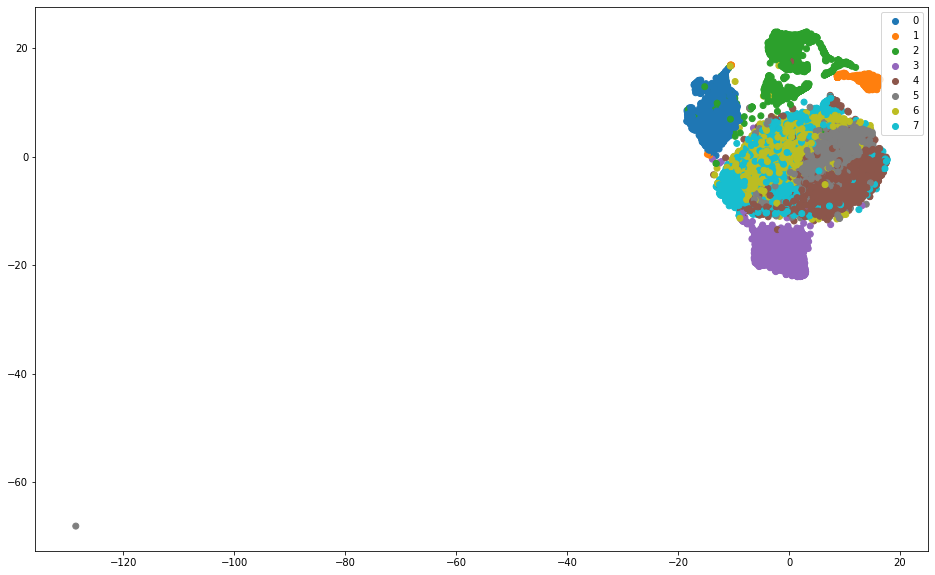

In [ ]:
dataset_labels = [0,1,2,3,4,5,6,7]

plt.figure(figsize=(16,10))
scatterplot = plt.scatter(
    x=data_TSNE[:,0], y=data_TSNE[:,1],
    c=our_labels,
    cmap="tab10"
)

handles, _ = scatterplot.legend_elements(prop='colors')
plt.legend(handles, dataset_labels)

In [11]:
def run_experiment(K, X, Y, epochs=10, hl1_neurons=400, hl2_neurons=10):

  print('Experiment results for k-means with k =', K, 'clusters:\n')
  print('Running k-means algorithm in order to get our pseudolabels: \n')

  kmeans_initial = KMeans(n_clusters=K, n_init=10).fit(X) 
  pseudo_labels = copy.deepcopy(kmeans_initial.labels_)
  real_labels = transform_clusters_to_labels(kmeans_initial.labels_, Y)

  # check TSNE representation of our features according to the k categories

  # print("Creating TSNE representation of our features according to the k categories...\n")

  # pseudolabels_indices = [i for i in range(K)]

  # plt.figure(figsize=(16,10)) 
  # kmeans_scatterplot = plt.scatter(
  #     x=data_TSNE[:,0], y=data_TSNE[:,1],
  #     c=pseudo_labels,
  #     cmap="gist_rainbow"
  # )

  # handles = kmeans_scatterplot.legend_elements(num=pseudolabels_indices)[0]
  # plt.legend(handles, pseudolabels_indices)

  # savestring = 'pseudolabels_TSNE_initial_space_k=' + str(K) + '.png'
  # plt.savefig(savestring)

  # find out accuracy of the algorithm in the initial space

  kmeans_initial_labels = kmeans_initial.labels_

  # the following metrics use the output of the clustering as input

  kmeans_initial_hungarian_acc = cluster_accuracy(Y, kmeans_initial_labels)[1]
  kmeans_initial_NMI = normalized_mutual_info_score(Y, kmeans_initial_labels)
  kmeans_initial_ARI = adjusted_rand_score(Y, kmeans_initial_labels)

  print("K_means greedy accuracy score (initial space, whole X set):",accuracy_score(Y, real_labels))
  print("K_means hungarian accuracy score (initial space, whole X set):",kmeans_initial_hungarian_acc)
  print("Normalised mutual info score (initial space, whole X set):",kmeans_initial_NMI)
  print("ARI (initial space, whole X set):",kmeans_initial_ARI, "\n")

  x_train, x_test, y_train, y_test = train_test_split(X, pseudo_labels, test_size=0.20) # we want a test set as well, so we split the initial set
  
  print("Number of representatitives in y_test:\n")
  # check_number_of_representatives(y_test)

  print('Preparing our data for the MLP model.\n')

  # first, the training dataset

  y_train = torch.from_numpy(y_train) # we need tensors in our MLP model
  y_train = y_train.type(torch.LongTensor) # need this dtype for MLP model
  x_train = torch.from_numpy(x_train)
  #x_train = x_train.unsqueeze(1) # in order to get a tensor of 4 dimensions (number of channels missing at first)
  x_train = x_train.double() # will need doubleTensor for our model
  my_train_dataset = CustomDataset(datapoints=x_train, labels=y_train)

  # then, the testing dataset

  y_test = torch.from_numpy(y_test) # we need tensors in our MLP model
  y_test = y_test.type(torch.LongTensor) # need this dtype for MLP model
  x_test = torch.from_numpy(x_test)
  #x_test = x_test.unsqueeze(1) # in order to get a tensor of 4 dimensions (number of channels missing at first)
  x_test = x_test.double() # will need doubleTensor for our model
  my_test_dataset = CustomDataset(datapoints=x_test, labels=y_test)

  # finally, the whole set, which will be run through the network in the end

  X = torch.from_numpy(X)
  #X = X.unsqueeze(1) # in order to get a tensor of 4 dimensions (number of channels missing at first)
  X = X.double() # will need doubleTensor for our model

  # using the MLP model on our data

  print('Using the MLP model on our data: \n')

  MLP_accuracy_scores = []
  kmeans_accuracy_scores = []
  kmeans_NMI_scores = []
  kmeans_ARI_scores = []
  k_means_silhouette_scores = []
  agglo_accuracy_scores = []
  agglo_NMI_scores = []
  agglo_ARI_scores = []
  MLP_test_accuracy_scores = []
  k_means_cluster_error_scores = []

  for i in range(10):

    print("ROUND NUMBER ",i + 1,":\n")
    MLP_model = MLP_module(input_dim=720,output_dim=K,train_dataset=my_train_dataset,test_dataset=my_test_dataset,valid_ratio=0.2,hl1_neurons=hl1_neurons, hl2_neurons=hl2_neurons, number_of_epochs=epochs)
    MLP_model.create_validation_set()
    MLP_model.define_dataLoaders()
    MLP_model.set_parameters()
    MLP_model.do_training()
    MLP_test_accuracy = MLP_model.calculate_loss()
    MLP_test_accuracy_scores.append(MLP_test_accuracy)

    # calculating stats
    MLP_trained_model = MLP_model.load_model() # load our model with its trained parameters

    # calculate outputs by running all the training images through the network
    MLP_outputs = MLP_model.forward(X)

    # the class with the highest energy is what we choose as pseudo-label-prediction
    predicted_pseudo_labels = torch.argmax(MLP_outputs, dim=1).cpu().detach().numpy()
    MLP_real_labels = transform_clusters_to_labels(predicted_pseudo_labels, Y)

    MLP_greedy_acc = accuracy_score(Y, MLP_real_labels)
    MLP_hungarian_acc = cluster_accuracy(Y, predicted_pseudo_labels)[1]
    MLP_accuracy_scores.append(MLP_hungarian_acc)

    print("\nMLP greedy accuracy score:", MLP_greedy_acc)
    print("MLP hungarian accuracy score:", MLP_hungarian_acc, "\n")
    
    print("Creating a k-means model on MLP-created space (with its vector outputs):\n")

    # Maybe we need Standar Scaler

    MLP_vectors = MLP_trained_model.get_hidden_representations(X.float()).detach().numpy()
    MLP_vectors = std_scaler.fit_transform(MLP_vectors)

    new_kmeans = KMeans(n_clusters=8, n_init=100).fit(MLP_vectors)

    kmeans_clusters = new_kmeans.labels_
    kmeans_cluster_error = new_kmeans.inertia_
    k_means_cluster_error_scores.append(kmeans_cluster_error)
    kmeans_greedy_labels = transform_clusters_to_labels(kmeans_clusters, Y)

    # print the stats on the transformed space
    kmeans_greedy_acc = accuracy_score(Y, kmeans_greedy_labels)
    kmeans_accuracy_scores.append(kmeans_greedy_acc)

    # These metrics as input they use the output of the clustering algorithm
    kmeans_hungarian_acc = cluster_accuracy(Y, kmeans_clusters)[1]
    kmeans_NMI = normalized_mutual_info_score(Y, kmeans_clusters)
    kmeans_ARI = adjusted_rand_score(Y, kmeans_clusters)

    kmeans_NMI_scores.append(kmeans_NMI)
    kmeans_ARI_scores.append(kmeans_ARI)

    k_means_silhouette_score = silhouette_score(MLP_vectors, kmeans_clusters)

    print("K-means with 8 clusters on MLP-transformed space stats: \n")
    print("K-means on MLP-transformed space greedy accuracy score:",kmeans_greedy_acc)
    print("K-means on MLP-transformed space hungarian accuracy score:",kmeans_hungarian_acc)
    print("Normalised mutual info score on k-means on MLP-transformed space:", kmeans_NMI)
    print("ARI score on k-means on MLP-transformed space:", kmeans_ARI)
    print("K-means cluster error on MLP-transformed space:", kmeans_cluster_error)
    print("K-means silhouette score on MLP-transformed space:", k_means_silhouette_score, "\n")

    k_means_silhouette_scores.append(k_means_silhouette_score)
    
    # do agglomerative clustering on the transformed space

    print("Doing agglomerative clustering on MLP output vectors:\n")
    aggloClustering = AgglomerativeClustering(n_clusters=8).fit(MLP_vectors)
    aggloClustering_clusters = aggloClustering.labels_
    agglo_greedy_labels = transform_clusters_to_labels(aggloClustering_clusters, Y)

    # print the stats on agglomerative clustering
    agglo_greedy_acc = accuracy_score(Y, agglo_greedy_labels)
    agglo_hungarian_acc = cluster_accuracy(Y, aggloClustering_clusters)[1]
    agglo_NMI = normalized_mutual_info_score(Y, aggloClustering_clusters)
    agglo_ARI = adjusted_rand_score(Y, aggloClustering_clusters)

    agglo_accuracy_scores.append(agglo_greedy_acc)
    agglo_NMI_scores.append(agglo_NMI)
    agglo_ARI_scores.append(agglo_ARI)

    print("Agglomerative clustering on MLP-transformed space greedy accuracy score:", agglo_greedy_acc)
    print("Agglomerative clustering on MLP-transformed space hungarian accuracy score:", agglo_hungarian_acc)
    print("Normalised mutual info score on agglomerative clustering on MLP-transformed space:",agglo_NMI, "\n")
    print("ARI score on agglomerative clustering on MLP-transformed space:", agglo_ARI, "\n")

  print("Average MLP accuracy score training at pseudolabels:", sum(MLP_accuracy_scores) / len(MLP_accuracy_scores), "\n")
  print("Average k-means accuracy score at latent space:", sum(kmeans_accuracy_scores) / len(kmeans_accuracy_scores), "\n")
  print("Average k-means NMI score at latent space:", sum(kmeans_NMI_scores) / len(kmeans_NMI_scores), "\n")
  print("Average k-means ARI score at latent space:", sum(kmeans_ARI_scores) / len(kmeans_ARI_scores), "\n")
  print("Average agglomerative clustering accuracy score at latent space:", sum(agglo_accuracy_scores) / len(agglo_accuracy_scores), "\n")
  print("Average agglomerative clustering NMI score at latent space:", sum(agglo_NMI_scores) / len(agglo_NMI_scores), "\n")
  print("Average agglomerative clustering ARI score at latent space:", sum(agglo_ARI_scores) / len(agglo_ARI_scores), "\n")
  print("Average MLP test accuracy score:", sum(MLP_test_accuracy_scores) / len(MLP_test_accuracy_scores), "\n")
  print("Average k-means silhouette score on MLP-transformed space:", sum(k_means_silhouette_scores) / len(k_means_silhouette_scores), "\n")
  print("Average k-means cluster error on MLP-transformed space:", sum(k_means_cluster_error_scores) / len(k_means_cluster_error_scores), "\n")

  return k_means_silhouette_scores

In [12]:
results_for_k_30 = run_experiment(30, our_data, our_labels, epochs=10, hl1_neurons=400, hl2_neurons=20)

Experiment results for k-means with k = 30 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space, whole X set): 0.8412
K_means hungarian accuracy score (initial space, whole X set): 0.8412
Normalised mutual info score (initial space, whole X set): 0.7673571057921875
ARI (initial space, whole X set): 0.6898803814982883 

Number of representatitives in y_test:

Preparing our data for the MLP model.

Using the MLP model on our data: 

ROUND NUMBER  1 :



Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 3.362 | Train Acc: 34.00%
	 Val. Loss: 3.395 |  Val. Acc: 21.09%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 3.287 | Train Acc: 53.31%
	 Val. Loss: 3.357 |  Val. Acc: 37.53%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 3.211 | Train Acc: 56.69%
	 Val. Loss: 3.269 |  Val. Acc: 43.36%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 3.118 | Train Acc: 58.38%
	 Val. Loss: 3.204 |  Val. Acc: 39.77%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 3.036 | Train Acc: 62.69%
	 Val. Loss: 3.157 |  Val. Acc: 46.02%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 2.961 | Train Acc: 69.69%
	 Val. Loss: 3.129 |  Val. Acc: 47.88%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 2.880 | Train Acc: 76.94%
	 Val. Loss: 3.086 |  Val. Acc: 52.44%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 2.810 | Train Acc: 82.06%
	 Val. Loss: 3.082 |  Val. Acc: 53.39%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 2.744 | Train Acc: 84.19%
	 Val. Loss: 3.047 |  Val. Acc: 52.44%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 0s
	Train Loss: 2.697 | Train Acc: 85.75%
	 Val. Loss: 3.032 |  Val. Acc: 53.19%


Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Test Loss: 3.021 | Test Acc: 54.88%

MLP greedy accuracy score: 0.8103
MLP hungarian accuracy score: 0.8103 

Creating a k-means model on MLP-created space (with its vector outputs):

K-means with 8 clusters on MLP-transformed space stats: 

K-means on MLP-transformed space greedy accuracy score: 0.7768
K-means on MLP-transformed space hungarian accuracy score: 0.7768
Normalised mutual info score on k-means on MLP-transformed space: 0.6849544837705329
ARI score on k-means on MLP-transformed space: 0.5999293655373256
K-means cluster error on MLP-transformed space: 183037.203125
K-means silhouette score on MLP-transformed space: 0.1809789 

Doing agglomerative clustering on MLP output vectors:

Agglomerative clustering on MLP-transformed space greedy accuracy score: 0.7484
Agglomerative clustering on MLP-transformed space hungarian accuracy score: 0.7484
Normalised mutual info score on agglomerative clustering on MLP-transformed space: 0.6889682935691314 

ARI score on agglomerative clus

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 3.346 | Train Acc: 23.38%
	 Val. Loss: 3.391 |  Val. Acc: 23.95%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 3.277 | Train Acc: 38.81%
	 Val. Loss: 3.354 |  Val. Acc: 28.62%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 3.211 | Train Acc: 46.81%
	 Val. Loss: 3.282 |  Val. Acc: 36.02%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 3.130 | Train Acc: 54.25%
	 Val. Loss: 3.196 |  Val. Acc: 43.64%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 3.043 | Train Acc: 62.31%
	 Val. Loss: 3.161 |  Val. Acc: 49.17%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 2.947 | Train Acc: 66.62%
	 Val. Loss: 3.111 |  Val. Acc: 47.67%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 1s
	Train Loss: 2.878 | Train Acc: 69.62%
	 Val. Loss: 3.058 |  Val. Acc: 50.80%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 2.826 | Train Acc: 72.50%
	 Val. Loss: 3.057 |  Val. Acc: 50.67%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 2.790 | Train Acc: 75.06%
	 Val. Loss: 3.071 |  Val. Acc: 50.12%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 0s
	Train Loss: 2.757 | Train Acc: 77.44%
	 Val. Loss: 3.053 |  Val. Acc: 49.00%


Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Test Loss: 3.052 | Test Acc: 49.66%

MLP greedy accuracy score: 0.7635
MLP hungarian accuracy score: 0.7635 

Creating a k-means model on MLP-created space (with its vector outputs):

K-means with 8 clusters on MLP-transformed space stats: 

K-means on MLP-transformed space greedy accuracy score: 0.7034
K-means on MLP-transformed space hungarian accuracy score: 0.7034
Normalised mutual info score on k-means on MLP-transformed space: 0.6150457744502904
ARI score on k-means on MLP-transformed space: 0.5017426757061189
K-means cluster error on MLP-transformed space: 176644.578125
K-means silhouette score on MLP-transformed space: 0.17154542 

Doing agglomerative clustering on MLP output vectors:

Agglomerative clustering on MLP-transformed space greedy accuracy score: 0.711
Agglomerative clustering on MLP-transformed space hungarian accuracy score: 0.711
Normalised mutual info score on agglomerative clustering on MLP-transformed space: 0.6522172915590271 

ARI score on agglomerative clust

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 3.360 | Train Acc: 27.12%
	 Val. Loss: 3.394 |  Val. Acc: 13.14%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 3.286 | Train Acc: 41.06%
	 Val. Loss: 3.364 |  Val. Acc: 36.62%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 3.221 | Train Acc: 46.25%
	 Val. Loss: 3.285 |  Val. Acc: 42.58%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 3.161 | Train Acc: 52.31%
	 Val. Loss: 3.206 |  Val. Acc: 42.05%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 3.101 | Train Acc: 57.00%
	 Val. Loss: 3.167 |  Val. Acc: 43.14%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 3.028 | Train Acc: 63.38%
	 Val. Loss: 3.160 |  Val. Acc: 42.14%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 2.955 | Train Acc: 68.12%
	 Val. Loss: 3.109 |  Val. Acc: 47.78%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 2.885 | Train Acc: 72.50%
	 Val. Loss: 3.115 |  Val. Acc: 50.88%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 2.824 | Train Acc: 77.12%
	 Val. Loss: 3.086 |  Val. Acc: 51.28%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 0s
	Train Loss: 2.786 | Train Acc: 78.06%
	 Val. Loss: 3.074 |  Val. Acc: 48.42%


Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Test Loss: 3.084 | Test Acc: 46.88%

MLP greedy accuracy score: 0.7412
MLP hungarian accuracy score: 0.7412 

Creating a k-means model on MLP-created space (with its vector outputs):

K-means with 8 clusters on MLP-transformed space stats: 

K-means on MLP-transformed space greedy accuracy score: 0.7255
K-means on MLP-transformed space hungarian accuracy score: 0.7255
Normalised mutual info score on k-means on MLP-transformed space: 0.625303402599303
ARI score on k-means on MLP-transformed space: 0.4985689204230166
K-means cluster error on MLP-transformed space: 174392.78125
K-means silhouette score on MLP-transformed space: 0.18264502 

Doing agglomerative clustering on MLP output vectors:

Agglomerative clustering on MLP-transformed space greedy accuracy score: 0.7512
Agglomerative clustering on MLP-transformed space hungarian accuracy score: 0.7512
Normalised mutual info score on agglomerative clustering on MLP-transformed space: 0.6842028793993726 

ARI score on agglomerative clust

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 3.348 | Train Acc: 29.38%
	 Val. Loss: 3.390 |  Val. Acc: 23.81%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 3.276 | Train Acc: 50.88%
	 Val. Loss: 3.352 |  Val. Acc: 38.09%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 3.192 | Train Acc: 55.25%
	 Val. Loss: 3.254 |  Val. Acc: 41.06%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 3.100 | Train Acc: 56.69%
	 Val. Loss: 3.185 |  Val. Acc: 40.98%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 3.018 | Train Acc: 59.31%
	 Val. Loss: 3.181 |  Val. Acc: 39.41%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 2.955 | Train Acc: 62.94%
	 Val. Loss: 3.132 |  Val. Acc: 40.50%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 2.902 | Train Acc: 67.00%
	 Val. Loss: 3.127 |  Val. Acc: 43.77%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 2.848 | Train Acc: 71.75%
	 Val. Loss: 3.105 |  Val. Acc: 44.27%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 2.797 | Train Acc: 75.94%
	 Val. Loss: 3.062 |  Val. Acc: 49.02%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 0s
	Train Loss: 2.749 | Train Acc: 78.44%
	 Val. Loss: 3.068 |  Val. Acc: 47.48%


Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Test Loss: 3.052 | Test Acc: 50.73%

MLP greedy accuracy score: 0.7812
MLP hungarian accuracy score: 0.7812 

Creating a k-means model on MLP-created space (with its vector outputs):

K-means with 8 clusters on MLP-transformed space stats: 

K-means on MLP-transformed space greedy accuracy score: 0.8331
K-means on MLP-transformed space hungarian accuracy score: 0.8331
Normalised mutual info score on k-means on MLP-transformed space: 0.7326197201270859
ARI score on k-means on MLP-transformed space: 0.6725632335110935
K-means cluster error on MLP-transformed space: 165805.546875
K-means silhouette score on MLP-transformed space: 0.21736474 

Doing agglomerative clustering on MLP output vectors:

Agglomerative clustering on MLP-transformed space greedy accuracy score: 0.8029
Agglomerative clustering on MLP-transformed space hungarian accuracy score: 0.8029
Normalised mutual info score on agglomerative clustering on MLP-transformed space: 0.7247018612830394 

ARI score on agglomerative clu

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 3.342 | Train Acc: 26.06%
	 Val. Loss: 3.391 |  Val. Acc: 25.95%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 3.262 | Train Acc: 39.81%
	 Val. Loss: 3.346 |  Val. Acc: 36.86%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 3.190 | Train Acc: 47.12%
	 Val. Loss: 3.264 |  Val. Acc: 38.19%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 3.110 | Train Acc: 54.69%
	 Val. Loss: 3.170 |  Val. Acc: 43.97%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 3.028 | Train Acc: 60.38%
	 Val. Loss: 3.154 |  Val. Acc: 44.78%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 1s
	Train Loss: 2.947 | Train Acc: 64.00%
	 Val. Loss: 3.113 |  Val. Acc: 47.75%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 2.891 | Train Acc: 66.31%
	 Val. Loss: 3.093 |  Val. Acc: 47.77%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 2.848 | Train Acc: 69.81%
	 Val. Loss: 3.079 |  Val. Acc: 49.34%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 2.805 | Train Acc: 75.00%
	 Val. Loss: 3.052 |  Val. Acc: 52.34%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 0s
	Train Loss: 2.763 | Train Acc: 78.62%
	 Val. Loss: 3.045 |  Val. Acc: 52.64%


Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Test Loss: 3.045 | Test Acc: 52.54%

MLP greedy accuracy score: 0.7557
MLP hungarian accuracy score: 0.7557 

Creating a k-means model on MLP-created space (with its vector outputs):

K-means with 8 clusters on MLP-transformed space stats: 

K-means on MLP-transformed space greedy accuracy score: 0.7048
K-means on MLP-transformed space hungarian accuracy score: 0.7048
Normalised mutual info score on k-means on MLP-transformed space: 0.6606523402842726
ARI score on k-means on MLP-transformed space: 0.5363095717361737
K-means cluster error on MLP-transformed space: 174675.953125
K-means silhouette score on MLP-transformed space: 0.16904372 

Doing agglomerative clustering on MLP output vectors:

Agglomerative clustering on MLP-transformed space greedy accuracy score: 0.7111
Agglomerative clustering on MLP-transformed space hungarian accuracy score: 0.7111
Normalised mutual info score on agglomerative clustering on MLP-transformed space: 0.6902995603699336 

ARI score on agglomerative clu

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 1s
	Train Loss: 3.331 | Train Acc: 22.69%
	 Val. Loss: 3.392 |  Val. Acc: 24.06%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 1s
	Train Loss: 3.259 | Train Acc: 36.25%
	 Val. Loss: 3.335 |  Val. Acc: 36.64%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 3.192 | Train Acc: 42.31%
	 Val. Loss: 3.239 |  Val. Acc: 39.75%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 3.121 | Train Acc: 47.56%
	 Val. Loss: 3.201 |  Val. Acc: 42.28%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 3.057 | Train Acc: 53.87%
	 Val. Loss: 3.146 |  Val. Acc: 43.91%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 2.984 | Train Acc: 61.12%
	 Val. Loss: 3.128 |  Val. Acc: 44.16%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 2.918 | Train Acc: 65.31%
	 Val. Loss: 3.110 |  Val. Acc: 47.09%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 2.865 | Train Acc: 68.12%
	 Val. Loss: 3.109 |  Val. Acc: 46.38%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 2.818 | Train Acc: 70.00%
	 Val. Loss: 3.071 |  Val. Acc: 46.28%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 0s
	Train Loss: 2.786 | Train Acc: 73.44%
	 Val. Loss: 3.058 |  Val. Acc: 48.00%


Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Test Loss: 3.055 | Test Acc: 47.12%

MLP greedy accuracy score: 0.8278
MLP hungarian accuracy score: 0.8278 

Creating a k-means model on MLP-created space (with its vector outputs):

K-means with 8 clusters on MLP-transformed space stats: 

K-means on MLP-transformed space greedy accuracy score: 0.8154
K-means on MLP-transformed space hungarian accuracy score: 0.8154
Normalised mutual info score on k-means on MLP-transformed space: 0.7206279593095614
ARI score on k-means on MLP-transformed space: 0.6653050290822419
K-means cluster error on MLP-transformed space: 167134.359375
K-means silhouette score on MLP-transformed space: 0.19614457 

Doing agglomerative clustering on MLP output vectors:

Agglomerative clustering on MLP-transformed space greedy accuracy score: 0.8004
Agglomerative clustering on MLP-transformed space hungarian accuracy score: 0.8004
Normalised mutual info score on agglomerative clustering on MLP-transformed space: 0.7427842246672796 

ARI score on agglomerative clu

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 3.349 | Train Acc: 34.50%
	 Val. Loss: 3.393 |  Val. Acc: 14.19%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 3.268 | Train Acc: 47.81%
	 Val. Loss: 3.358 |  Val. Acc: 36.42%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 3.190 | Train Acc: 50.44%
	 Val. Loss: 3.265 |  Val. Acc: 40.19%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 3.111 | Train Acc: 58.00%
	 Val. Loss: 3.200 |  Val. Acc: 42.84%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 3.035 | Train Acc: 61.56%
	 Val. Loss: 3.161 |  Val. Acc: 44.69%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 2.967 | Train Acc: 66.69%
	 Val. Loss: 3.144 |  Val. Acc: 45.88%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 2.900 | Train Acc: 70.06%
	 Val. Loss: 3.105 |  Val. Acc: 47.95%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 2.846 | Train Acc: 71.44%
	 Val. Loss: 3.082 |  Val. Acc: 49.17%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 2.800 | Train Acc: 73.31%
	 Val. Loss: 3.065 |  Val. Acc: 50.56%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 0s
	Train Loss: 2.768 | Train Acc: 75.38%
	 Val. Loss: 3.047 |  Val. Acc: 49.80%


Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Test Loss: 3.049 | Test Acc: 48.83%

MLP greedy accuracy score: 0.7956
MLP hungarian accuracy score: 0.7956 

Creating a k-means model on MLP-created space (with its vector outputs):

K-means with 8 clusters on MLP-transformed space stats: 

K-means on MLP-transformed space greedy accuracy score: 0.7948
K-means on MLP-transformed space hungarian accuracy score: 0.7948
Normalised mutual info score on k-means on MLP-transformed space: 0.6980118120000662
ARI score on k-means on MLP-transformed space: 0.6374481911579003
K-means cluster error on MLP-transformed space: 168012.234375
K-means silhouette score on MLP-transformed space: 0.20176245 

Doing agglomerative clustering on MLP output vectors:

Agglomerative clustering on MLP-transformed space greedy accuracy score: 0.7589
Agglomerative clustering on MLP-transformed space hungarian accuracy score: 0.7589
Normalised mutual info score on agglomerative clustering on MLP-transformed space: 0.6988067059482794 

ARI score on agglomerative clu

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 3.341 | Train Acc: 25.25%
	 Val. Loss: 3.395 |  Val. Acc: 15.38%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 3.252 | Train Acc: 37.75%
	 Val. Loss: 3.357 |  Val. Acc: 29.91%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 3.188 | Train Acc: 42.31%
	 Val. Loss: 3.257 |  Val. Acc: 33.48%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 3.131 | Train Acc: 49.25%
	 Val. Loss: 3.209 |  Val. Acc: 36.58%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 3.074 | Train Acc: 57.00%
	 Val. Loss: 3.161 |  Val. Acc: 44.27%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 2.992 | Train Acc: 61.44%
	 Val. Loss: 3.146 |  Val. Acc: 46.62%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 2.926 | Train Acc: 65.62%
	 Val. Loss: 3.110 |  Val. Acc: 46.06%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 2.864 | Train Acc: 68.81%
	 Val. Loss: 3.091 |  Val. Acc: 48.91%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 2.822 | Train Acc: 70.38%
	 Val. Loss: 3.060 |  Val. Acc: 47.27%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 0s
	Train Loss: 2.793 | Train Acc: 72.81%
	 Val. Loss: 3.065 |  Val. Acc: 49.98%


Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Test Loss: 3.051 | Test Acc: 48.00%

MLP greedy accuracy score: 0.7664
MLP hungarian accuracy score: 0.7664 

Creating a k-means model on MLP-created space (with its vector outputs):

K-means with 8 clusters on MLP-transformed space stats: 

K-means on MLP-transformed space greedy accuracy score: 0.7294
K-means on MLP-transformed space hungarian accuracy score: 0.7294
Normalised mutual info score on k-means on MLP-transformed space: 0.6212007723230643
ARI score on k-means on MLP-transformed space: 0.5083101928480346
K-means cluster error on MLP-transformed space: 153764.15625
K-means silhouette score on MLP-transformed space: 0.20038791 

Doing agglomerative clustering on MLP output vectors:

Agglomerative clustering on MLP-transformed space greedy accuracy score: 0.775
Agglomerative clustering on MLP-transformed space hungarian accuracy score: 0.775
Normalised mutual info score on agglomerative clustering on MLP-transformed space: 0.6959589974059879 

ARI score on agglomerative cluste

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 3.346 | Train Acc: 26.44%
	 Val. Loss: 3.395 |  Val. Acc: 11.77%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 3.267 | Train Acc: 37.44%
	 Val. Loss: 3.334 |  Val. Acc: 35.92%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 3.203 | Train Acc: 46.69%
	 Val. Loss: 3.250 |  Val. Acc: 38.25%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 3.142 | Train Acc: 51.12%
	 Val. Loss: 3.188 |  Val. Acc: 42.27%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 3.077 | Train Acc: 53.62%
	 Val. Loss: 3.192 |  Val. Acc: 43.72%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 3.014 | Train Acc: 59.00%
	 Val. Loss: 3.132 |  Val. Acc: 46.88%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 2.951 | Train Acc: 66.44%
	 Val. Loss: 3.121 |  Val. Acc: 47.92%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 2.878 | Train Acc: 72.88%
	 Val. Loss: 3.067 |  Val. Acc: 50.77%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 2.811 | Train Acc: 76.44%
	 Val. Loss: 3.063 |  Val. Acc: 49.83%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 0s
	Train Loss: 2.765 | Train Acc: 77.56%
	 Val. Loss: 3.088 |  Val. Acc: 46.89%


Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Test Loss: 3.055 | Test Acc: 50.20%

MLP greedy accuracy score: 0.7607
MLP hungarian accuracy score: 0.7607 

Creating a k-means model on MLP-created space (with its vector outputs):

K-means with 8 clusters on MLP-transformed space stats: 

K-means on MLP-transformed space greedy accuracy score: 0.7969
K-means on MLP-transformed space hungarian accuracy score: 0.7969
Normalised mutual info score on k-means on MLP-transformed space: 0.6965162436653504
ARI score on k-means on MLP-transformed space: 0.6370573361210957
K-means cluster error on MLP-transformed space: 163334.453125
K-means silhouette score on MLP-transformed space: 0.20115656 

Doing agglomerative clustering on MLP output vectors:

Agglomerative clustering on MLP-transformed space greedy accuracy score: 0.7457
Agglomerative clustering on MLP-transformed space hungarian accuracy score: 0.7457
Normalised mutual info score on agglomerative clustering on MLP-transformed space: 0.677752465156163 

ARI score on agglomerative clus

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 3.350 | Train Acc: 23.31%
	 Val. Loss: 3.392 |  Val. Acc: 18.91%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 3.266 | Train Acc: 43.94%
	 Val. Loss: 3.357 |  Val. Acc: 33.58%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 3.184 | Train Acc: 49.44%
	 Val. Loss: 3.268 |  Val. Acc: 40.38%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 3.106 | Train Acc: 53.37%
	 Val. Loss: 3.192 |  Val. Acc: 39.58%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 3.033 | Train Acc: 57.81%
	 Val. Loss: 3.170 |  Val. Acc: 42.75%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 2.968 | Train Acc: 62.44%
	 Val. Loss: 3.116 |  Val. Acc: 45.94%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 2.904 | Train Acc: 68.50%
	 Val. Loss: 3.093 |  Val. Acc: 50.19%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 2.846 | Train Acc: 72.25%
	 Val. Loss: 3.069 |  Val. Acc: 51.73%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 2.798 | Train Acc: 74.00%
	 Val. Loss: 3.056 |  Val. Acc: 52.17%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 0s
	Train Loss: 2.765 | Train Acc: 75.00%
	 Val. Loss: 3.051 |  Val. Acc: 50.66%


Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Test Loss: 3.043 | Test Acc: 51.66%

MLP greedy accuracy score: 0.8282
MLP hungarian accuracy score: 0.8282 

Creating a k-means model on MLP-created space (with its vector outputs):

K-means with 8 clusters on MLP-transformed space stats: 

K-means on MLP-transformed space greedy accuracy score: 0.8409
K-means on MLP-transformed space hungarian accuracy score: 0.8409
Normalised mutual info score on k-means on MLP-transformed space: 0.7291097305148503
ARI score on k-means on MLP-transformed space: 0.6829570101720821
K-means cluster error on MLP-transformed space: 179935.1875
K-means silhouette score on MLP-transformed space: 0.19958615 

Doing agglomerative clustering on MLP output vectors:

Agglomerative clustering on MLP-transformed space greedy accuracy score: 0.8102
Agglomerative clustering on MLP-transformed space hungarian accuracy score: 0.8102
Normalised mutual info score on agglomerative clustering on MLP-transformed space: 0.7273542236659547 

ARI score on agglomerative clust

In [ ]:
results_for_k_40 = run_experiment(40, our_data, our_labels, epochs=10, hl1_neurons=100, hl2_neurons=20)

Experiment results for k-means with k = 40 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space, whole X set): 0.85155
K_means hungarian accuracy score (initial space, whole X set): 0.85155
Normalised mutual info score (initial space, whole X set): 0.781351067275381
ARI (initial space, whole X set): 0.7192226801621641 

Number of representatitives in y_test:

Preparing our data for the MLP model.

Using the MLP model on our data: 

ROUND NUMBER  1 :



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 3.631 | Train Acc: 28.94%
	 Val. Loss: 3.564 |  Val. Acc: 36.55%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 3.495 | Train Acc: 44.12%
	 Val. Loss: 3.449 |  Val. Acc: 45.40%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 3.347 | Train Acc: 52.47%
	 Val. Loss: 3.343 |  Val. Acc: 50.62%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 3.232 | Train Acc: 59.66%
	 Val. Loss: 3.291 |  Val. Acc: 53.91%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 3.153 | Train Acc: 65.16%
	 Val. Loss: 3.241 |  Val. Acc: 58.61%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 3.086 | Train Acc: 70.66%
	 Val. Loss: 3.199 |  Val. Acc: 63.59%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 3.031 | Train Acc: 76.38%
	 Val. Loss: 3.165 |  Val. Acc: 65.07%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 2.986 | Train Acc: 79.22%
	 Val. Loss: 3.129 |  Val. Acc: 68.84%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 2.939 | Train Acc: 82.97%
	 Val. Loss: 3.112 |  Val. Acc: 68.68%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 0s
	Train Loss: 2.911 | Train Acc: 85.12%
	 Val. Loss: 3.104 |  Val. Acc: 70.44%


Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

Test Loss: 3.101 | Test Acc: 70.98%

MLP greedy accuracy score: 0.82145
MLP hungarian accuracy score: 0.82145 

Creating a k-means model on MLP-created space (with its vector outputs):

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.001s...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 20000 samples in 8.925s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for sample 13000 / 20000
[t-SNE] Computed conditional probabilities for sample 14000 / 20000

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 3.633 | Train Acc: 21.81%
	 Val. Loss: 3.578 |  Val. Acc: 29.73%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 3.520 | Train Acc: 37.47%
	 Val. Loss: 3.502 |  Val. Acc: 39.38%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 3.408 | Train Acc: 48.72%
	 Val. Loss: 3.383 |  Val. Acc: 48.15%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 3.267 | Train Acc: 55.69%
	 Val. Loss: 3.321 |  Val. Acc: 49.45%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 1s
	Train Loss: 3.192 | Train Acc: 59.13%
	 Val. Loss: 3.289 |  Val. Acc: 51.12%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 3.144 | Train Acc: 62.97%
	 Val. Loss: 3.257 |  Val. Acc: 54.02%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 3.078 | Train Acc: 70.94%
	 Val. Loss: 3.193 |  Val. Acc: 61.68%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 3.010 | Train Acc: 78.44%
	 Val. Loss: 3.154 |  Val. Acc: 66.30%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 2.941 | Train Acc: 85.75%
	 Val. Loss: 3.117 |  Val. Acc: 70.62%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 0s
	Train Loss: 2.893 | Train Acc: 88.62%
	 Val. Loss: 3.108 |  Val. Acc: 69.62%


Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

Test Loss: 3.103 | Test Acc: 70.41%

MLP greedy accuracy score: 0.8178
MLP hungarian accuracy score: 0.8178 

Creating a k-means model on MLP-created space (with its vector outputs):

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.002s...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 20000 samples in 10.028s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for sample 13000 / 20000
[t-SNE] Computed conditional probabilities for sample 14000 / 2000

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 3.639 | Train Acc: 19.03%
	 Val. Loss: 3.588 |  Val. Acc: 29.30%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 3.535 | Train Acc: 37.47%
	 Val. Loss: 3.499 |  Val. Acc: 39.36%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 3.389 | Train Acc: 45.56%
	 Val. Loss: 3.384 |  Val. Acc: 42.52%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 3.267 | Train Acc: 55.75%
	 Val. Loss: 3.312 |  Val. Acc: 53.24%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 3.161 | Train Acc: 65.84%
	 Val. Loss: 3.250 |  Val. Acc: 55.75%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 3.102 | Train Acc: 67.59%
	 Val. Loss: 3.236 |  Val. Acc: 55.88%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 3.060 | Train Acc: 71.25%
	 Val. Loss: 3.209 |  Val. Acc: 59.74%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 3.011 | Train Acc: 76.81%
	 Val. Loss: 3.169 |  Val. Acc: 64.35%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 2.960 | Train Acc: 82.69%
	 Val. Loss: 3.131 |  Val. Acc: 68.03%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 0s
	Train Loss: 2.913 | Train Acc: 86.66%
	 Val. Loss: 3.114 |  Val. Acc: 68.70%


Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

Test Loss: 3.105 | Test Acc: 69.82%

MLP greedy accuracy score: 0.8375
MLP hungarian accuracy score: 0.8375 

Creating a k-means model on MLP-created space (with its vector outputs):

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.001s...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 20000 samples in 9.324s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for sample 13000 / 20000
[t-SNE] Computed conditional probabilities for sample 14000 / 20000

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 3.627 | Train Acc: 22.84%
	 Val. Loss: 3.561 |  Val. Acc: 27.38%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 3.522 | Train Acc: 36.00%
	 Val. Loss: 3.485 |  Val. Acc: 39.96%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 3.399 | Train Acc: 45.81%
	 Val. Loss: 3.373 |  Val. Acc: 44.03%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 3.290 | Train Acc: 51.41%
	 Val. Loss: 3.320 |  Val. Acc: 52.48%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 3.192 | Train Acc: 62.91%
	 Val. Loss: 3.249 |  Val. Acc: 57.90%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 3.115 | Train Acc: 66.38%
	 Val. Loss: 3.217 |  Val. Acc: 58.84%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 3.063 | Train Acc: 72.00%
	 Val. Loss: 3.175 |  Val. Acc: 65.14%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 2.990 | Train Acc: 79.88%
	 Val. Loss: 3.144 |  Val. Acc: 66.73%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 2.944 | Train Acc: 82.84%
	 Val. Loss: 3.125 |  Val. Acc: 67.88%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 0s
	Train Loss: 2.916 | Train Acc: 84.59%
	 Val. Loss: 3.117 |  Val. Acc: 68.12%


Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

Test Loss: 3.114 | Test Acc: 68.23%

MLP greedy accuracy score: 0.8357
MLP hungarian accuracy score: 0.8357 

Creating a k-means model on MLP-created space (with its vector outputs):

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.001s...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 20000 samples in 10.041s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for sample 13000 / 20000
[t-SNE] Computed conditional probabilities for sample 14000 / 2000

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 3.624 | Train Acc: 25.16%
	 Val. Loss: 3.557 |  Val. Acc: 34.22%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 3.494 | Train Acc: 42.31%
	 Val. Loss: 3.435 |  Val. Acc: 41.95%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 3.343 | Train Acc: 50.72%
	 Val. Loss: 3.342 |  Val. Acc: 49.32%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 3.227 | Train Acc: 59.09%
	 Val. Loss: 3.282 |  Val. Acc: 55.27%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 3.132 | Train Acc: 69.06%
	 Val. Loss: 3.221 |  Val. Acc: 59.11%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 3.059 | Train Acc: 72.72%
	 Val. Loss: 3.200 |  Val. Acc: 61.19%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 3.011 | Train Acc: 76.75%
	 Val. Loss: 3.168 |  Val. Acc: 64.44%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 2.965 | Train Acc: 81.81%
	 Val. Loss: 3.139 |  Val. Acc: 67.50%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 2.929 | Train Acc: 85.09%
	 Val. Loss: 3.127 |  Val. Acc: 68.98%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 0s
	Train Loss: 2.893 | Train Acc: 87.97%
	 Val. Loss: 3.106 |  Val. Acc: 69.62%


Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

Test Loss: 3.103 | Test Acc: 69.99%

MLP greedy accuracy score: 0.8219
MLP hungarian accuracy score: 0.8219 

Creating a k-means model on MLP-created space (with its vector outputs):

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.001s...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 20000 samples in 9.320s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for sample 13000 / 20000
[t-SNE] Computed conditional probabilities for sample 14000 / 20000

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 3.636 | Train Acc: 24.78%
	 Val. Loss: 3.568 |  Val. Acc: 37.09%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 3.509 | Train Acc: 44.53%
	 Val. Loss: 3.460 |  Val. Acc: 43.30%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 3.364 | Train Acc: 50.50%
	 Val. Loss: 3.373 |  Val. Acc: 47.89%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 3.255 | Train Acc: 56.78%
	 Val. Loss: 3.316 |  Val. Acc: 50.91%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 3.175 | Train Acc: 64.19%
	 Val. Loss: 3.270 |  Val. Acc: 56.38%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 3.102 | Train Acc: 70.91%
	 Val. Loss: 3.223 |  Val. Acc: 58.45%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 3.049 | Train Acc: 72.75%
	 Val. Loss: 3.210 |  Val. Acc: 58.69%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 3.001 | Train Acc: 79.28%
	 Val. Loss: 3.158 |  Val. Acc: 66.83%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 2.928 | Train Acc: 87.28%
	 Val. Loss: 3.118 |  Val. Acc: 69.60%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 0s
	Train Loss: 2.885 | Train Acc: 88.84%
	 Val. Loss: 3.116 |  Val. Acc: 69.23%


Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

Test Loss: 3.117 | Test Acc: 68.70%

MLP greedy accuracy score: 0.82945
MLP hungarian accuracy score: 0.82945 

Creating a k-means model on MLP-created space (with its vector outputs):

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.001s...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 20000 samples in 9.992s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for sample 13000 / 20000
[t-SNE] Computed conditional probabilities for sample 14000 / 20000

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 3.640 | Train Acc: 25.91%
	 Val. Loss: 3.578 |  Val. Acc: 38.42%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 3.510 | Train Acc: 44.25%
	 Val. Loss: 3.454 |  Val. Acc: 42.29%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 3.375 | Train Acc: 52.72%
	 Val. Loss: 3.370 |  Val. Acc: 49.35%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 3.250 | Train Acc: 61.66%
	 Val. Loss: 3.287 |  Val. Acc: 56.74%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 3.139 | Train Acc: 69.38%
	 Val. Loss: 3.225 |  Val. Acc: 61.27%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 3.054 | Train Acc: 75.28%
	 Val. Loss: 3.187 |  Val. Acc: 64.64%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 2.998 | Train Acc: 77.97%
	 Val. Loss: 3.168 |  Val. Acc: 63.81%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 2.970 | Train Acc: 79.28%
	 Val. Loss: 3.163 |  Val. Acc: 64.24%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 2.941 | Train Acc: 81.72%
	 Val. Loss: 3.148 |  Val. Acc: 65.67%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 0s
	Train Loss: 2.917 | Train Acc: 84.59%
	 Val. Loss: 3.136 |  Val. Acc: 66.59%


Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

Test Loss: 3.128 | Test Acc: 66.74%

MLP greedy accuracy score: 0.8098
MLP hungarian accuracy score: 0.8098 

Creating a k-means model on MLP-created space (with its vector outputs):



/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.001s...
[t-SNE] Computed neighbors for 20000 samples in 9.081s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for sam

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 3.642 | Train Acc: 30.53%
	 Val. Loss: 3.575 |  Val. Acc: 41.23%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 3.512 | Train Acc: 48.78%
	 Val. Loss: 3.455 |  Val. Acc: 49.63%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 3.351 | Train Acc: 53.94%
	 Val. Loss: 3.339 |  Val. Acc: 51.59%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 3.240 | Train Acc: 57.81%
	 Val. Loss: 3.289 |  Val. Acc: 54.93%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 3.157 | Train Acc: 64.81%
	 Val. Loss: 3.239 |  Val. Acc: 58.09%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 3.094 | Train Acc: 71.41%
	 Val. Loss: 3.205 |  Val. Acc: 63.42%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 3.017 | Train Acc: 80.03%
	 Val. Loss: 3.157 |  Val. Acc: 67.10%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 2.954 | Train Acc: 83.50%
	 Val. Loss: 3.143 |  Val. Acc: 67.05%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 2.919 | Train Acc: 84.66%
	 Val. Loss: 3.127 |  Val. Acc: 67.28%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 0s
	Train Loss: 2.900 | Train Acc: 85.72%
	 Val. Loss: 3.116 |  Val. Acc: 68.55%


Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

Test Loss: 3.113 | Test Acc: 68.80%

MLP greedy accuracy score: 0.83085
MLP hungarian accuracy score: 0.83085 

Creating a k-means model on MLP-created space (with its vector outputs):

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.001s...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 20000 samples in 10.135s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for sample 13000 / 20000
[t-SNE] Computed conditional probabilities for sample 14000 / 2000

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 1s
	Train Loss: 3.640 | Train Acc: 20.97%
	 Val. Loss: 3.583 |  Val. Acc: 30.90%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 3.508 | Train Acc: 40.16%
	 Val. Loss: 3.453 |  Val. Acc: 42.02%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 3.356 | Train Acc: 50.03%
	 Val. Loss: 3.358 |  Val. Acc: 49.19%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 3.248 | Train Acc: 57.56%
	 Val. Loss: 3.293 |  Val. Acc: 54.78%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 3.149 | Train Acc: 68.00%
	 Val. Loss: 3.214 |  Val. Acc: 63.26%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 3.051 | Train Acc: 76.25%
	 Val. Loss: 3.153 |  Val. Acc: 67.12%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 2.984 | Train Acc: 81.09%
	 Val. Loss: 3.125 |  Val. Acc: 70.34%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 2.932 | Train Acc: 85.38%
	 Val. Loss: 3.107 |  Val. Acc: 70.40%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 2.899 | Train Acc: 87.19%
	 Val. Loss: 3.092 |  Val. Acc: 71.55%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 0s
	Train Loss: 2.880 | Train Acc: 87.97%
	 Val. Loss: 3.085 |  Val. Acc: 70.77%


Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

Test Loss: 3.073 | Test Acc: 72.79%

MLP greedy accuracy score: 0.8121
MLP hungarian accuracy score: 0.8121 

Creating a k-means model on MLP-created space (with its vector outputs):



/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.002s...
[t-SNE] Computed neighbors for 20000 samples in 10.144s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for sa

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 3.617 | Train Acc: 25.31%
	 Val. Loss: 3.542 |  Val. Acc: 36.16%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 3.488 | Train Acc: 44.25%
	 Val. Loss: 3.455 |  Val. Acc: 43.27%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 3.369 | Train Acc: 48.16%
	 Val. Loss: 3.370 |  Val. Acc: 46.56%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 3.268 | Train Acc: 55.72%
	 Val. Loss: 3.303 |  Val. Acc: 51.25%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 3.182 | Train Acc: 60.84%
	 Val. Loss: 3.262 |  Val. Acc: 54.67%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 3.108 | Train Acc: 68.41%
	 Val. Loss: 3.216 |  Val. Acc: 57.75%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 3.051 | Train Acc: 72.81%
	 Val. Loss: 3.191 |  Val. Acc: 59.82%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 3.011 | Train Acc: 75.81%
	 Val. Loss: 3.185 |  Val. Acc: 60.41%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 2.984 | Train Acc: 77.38%
	 Val. Loss: 3.176 |  Val. Acc: 61.23%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 0s
	Train Loss: 2.958 | Train Acc: 79.81%
	 Val. Loss: 3.141 |  Val. Acc: 64.51%


Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

Test Loss: 3.136 | Test Acc: 65.10%

MLP greedy accuracy score: 0.80875
MLP hungarian accuracy score: 0.80875 

Creating a k-means model on MLP-created space (with its vector outputs):



/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.002s...
[t-SNE] Computed neighbors for 20000 samples in 9.871s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for sam

In [ ]:
results_for_k_6 = run_experiment(6, our_data, our_labels, epochs=10, hl1_neurons=400, hl2_neurons=20)

Experiment results for k-means with k = 6 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space, whole X set): 0.4704
K_means hungarian accuracy score (initial space, whole X set): 0.4704
Normalised mutual info score (initial space, whole X set): 0.42554641356153106
ARI (initial space, whole X set): 0.2524055463556529 

Number of representatitives in y_test:

Preparing our data for the MLP model.

Using the MLP model on our data: 

ROUND NUMBER  1 :



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 1s
	Train Loss: 1.465 | Train Acc: 83.25%
	 Val. Loss: 1.334 |  Val. Acc: 90.44%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 1s
	Train Loss: 1.273 | Train Acc: 92.44%
	 Val. Loss: 1.244 |  Val. Acc: 91.31%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 1s
	Train Loss: 1.173 | Train Acc: 96.50%
	 Val. Loss: 1.189 |  Val. Acc: 92.31%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 1s
	Train Loss: 1.124 | Train Acc: 97.88%
	 Val. Loss: 1.179 |  Val. Acc: 90.94%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 1s
	Train Loss: 1.097 | Train Acc: 98.56%
	 Val. Loss: 1.173 |  Val. Acc: 90.38%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 1s
	Train Loss: 1.077 | Train Acc: 99.50%
	 Val. Loss: 1.159 |  Val. Acc: 90.91%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 1s
	Train Loss: 1.069 | Train Acc: 99.53%
	 Val. Loss: 1.156 |  Val. Acc: 91.05%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 1s
	Train Loss: 1.060 | Train Acc: 99.72%
	 Val. Loss: 1.151 |  Val. Acc: 91.09%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 1s
	Train Loss: 1.059 | Train Acc: 99.72%
	 Val. Loss: 1.150 |  Val. Acc: 90.71%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 1s
	Train Loss: 1.056 | Train Acc: 99.84%
	 Val. Loss: 1.147 |  Val. Acc: 91.12%


Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

Test Loss: 1.151 | Test Acc: 90.72%

MLP greedy accuracy score: 0.46985
MLP hungarian accuracy score: 0.46985 

Creating a k-means model on MLP-created space (with its vector outputs):



/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.001s...
[t-SNE] Computed neighbors for 20000 samples in 9.896s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for sam

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 1s
	Train Loss: 1.447 | Train Acc: 82.34%
	 Val. Loss: 1.312 |  Val. Acc: 90.72%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 1s
	Train Loss: 1.254 | Train Acc: 93.22%
	 Val. Loss: 1.228 |  Val. Acc: 91.58%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 1s
	Train Loss: 1.169 | Train Acc: 95.84%
	 Val. Loss: 1.190 |  Val. Acc: 92.60%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 1s
	Train Loss: 1.118 | Train Acc: 98.25%
	 Val. Loss: 1.163 |  Val. Acc: 91.95%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 1s
	Train Loss: 1.093 | Train Acc: 98.66%
	 Val. Loss: 1.154 |  Val. Acc: 91.84%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 1s
	Train Loss: 1.080 | Train Acc: 98.94%
	 Val. Loss: 1.158 |  Val. Acc: 91.21%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 1s
	Train Loss: 1.072 | Train Acc: 99.22%
	 Val. Loss: 1.163 |  Val. Acc: 90.28%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 1s
	Train Loss: 1.065 | Train Acc: 99.50%
	 Val. Loss: 1.151 |  Val. Acc: 90.95%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 1s
	Train Loss: 1.060 | Train Acc: 99.66%
	 Val. Loss: 1.157 |  Val. Acc: 90.17%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 1s
	Train Loss: 1.056 | Train Acc: 99.75%
	 Val. Loss: 1.149 |  Val. Acc: 90.71%


Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

Test Loss: 1.142 | Test Acc: 91.62%

MLP greedy accuracy score: 0.48225
MLP hungarian accuracy score: 0.48225 

Creating a k-means model on MLP-created space (with its vector outputs):



/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.001s...
[t-SNE] Computed neighbors for 20000 samples in 9.627s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for sam

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 1s
	Train Loss: 1.432 | Train Acc: 84.06%
	 Val. Loss: 1.302 |  Val. Acc: 91.91%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 1s
	Train Loss: 1.245 | Train Acc: 93.75%
	 Val. Loss: 1.218 |  Val. Acc: 92.80%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 1s
	Train Loss: 1.159 | Train Acc: 96.50%
	 Val. Loss: 1.177 |  Val. Acc: 92.57%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 1s
	Train Loss: 1.116 | Train Acc: 98.25%
	 Val. Loss: 1.161 |  Val. Acc: 91.89%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 1s
	Train Loss: 1.094 | Train Acc: 98.25%
	 Val. Loss: 1.150 |  Val. Acc: 92.25%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 1s
	Train Loss: 1.080 | Train Acc: 98.91%
	 Val. Loss: 1.152 |  Val. Acc: 91.34%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 1s
	Train Loss: 1.076 | Train Acc: 99.09%
	 Val. Loss: 1.148 |  Val. Acc: 91.34%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 1s
	Train Loss: 1.065 | Train Acc: 99.50%
	 Val. Loss: 1.147 |  Val. Acc: 90.98%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 1s
	Train Loss: 1.059 | Train Acc: 99.78%
	 Val. Loss: 1.149 |  Val. Acc: 90.91%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 1s
	Train Loss: 1.056 | Train Acc: 99.78%
	 Val. Loss: 1.146 |  Val. Acc: 91.07%


Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

Test Loss: 1.144 | Test Acc: 91.17%

MLP greedy accuracy score: 0.4701
MLP hungarian accuracy score: 0.4701 

Creating a k-means model on MLP-created space (with its vector outputs):



/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.001s...
[t-SNE] Computed neighbors for 20000 samples in 9.059s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for sam

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 1s
	Train Loss: 1.438 | Train Acc: 82.72%
	 Val. Loss: 1.300 |  Val. Acc: 89.87%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 1s
	Train Loss: 1.246 | Train Acc: 92.09%
	 Val. Loss: 1.222 |  Val. Acc: 91.33%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 1s
	Train Loss: 1.169 | Train Acc: 95.41%
	 Val. Loss: 1.183 |  Val. Acc: 92.12%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 1s
	Train Loss: 1.122 | Train Acc: 97.66%
	 Val. Loss: 1.174 |  Val. Acc: 91.34%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 1s
	Train Loss: 1.094 | Train Acc: 98.44%
	 Val. Loss: 1.159 |  Val. Acc: 92.05%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 1s
	Train Loss: 1.081 | Train Acc: 98.88%
	 Val. Loss: 1.163 |  Val. Acc: 90.96%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 1s
	Train Loss: 1.075 | Train Acc: 99.16%
	 Val. Loss: 1.152 |  Val. Acc: 91.03%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 1s
	Train Loss: 1.065 | Train Acc: 99.53%
	 Val. Loss: 1.150 |  Val. Acc: 91.20%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 1s
	Train Loss: 1.058 | Train Acc: 99.78%
	 Val. Loss: 1.148 |  Val. Acc: 91.09%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 1s
	Train Loss: 1.054 | Train Acc: 99.88%
	 Val. Loss: 1.148 |  Val. Acc: 90.81%


Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

Test Loss: 1.153 | Test Acc: 90.75%

MLP greedy accuracy score: 0.47305
MLP hungarian accuracy score: 0.47305 

Creating a k-means model on MLP-created space (with its vector outputs):



/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.001s...
[t-SNE] Computed neighbors for 20000 samples in 9.770s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for sam

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 1s
	Train Loss: 1.452 | Train Acc: 84.12%
	 Val. Loss: 1.319 |  Val. Acc: 91.35%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 1s
	Train Loss: 1.266 | Train Acc: 92.94%
	 Val. Loss: 1.222 |  Val. Acc: 92.77%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 1s
	Train Loss: 1.173 | Train Acc: 96.16%
	 Val. Loss: 1.183 |  Val. Acc: 92.69%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 1s
	Train Loss: 1.121 | Train Acc: 98.22%
	 Val. Loss: 1.171 |  Val. Acc: 91.71%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 1s
	Train Loss: 1.095 | Train Acc: 98.94%
	 Val. Loss: 1.154 |  Val. Acc: 92.05%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 1s
	Train Loss: 1.075 | Train Acc: 99.41%
	 Val. Loss: 1.157 |  Val. Acc: 91.40%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 1s
	Train Loss: 1.073 | Train Acc: 99.31%
	 Val. Loss: 1.153 |  Val. Acc: 91.14%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 1s
	Train Loss: 1.064 | Train Acc: 99.56%
	 Val. Loss: 1.150 |  Val. Acc: 90.95%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 1s
	Train Loss: 1.062 | Train Acc: 99.62%
	 Val. Loss: 1.150 |  Val. Acc: 90.84%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 1s
	Train Loss: 1.056 | Train Acc: 99.69%
	 Val. Loss: 1.146 |  Val. Acc: 91.25%


Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

Test Loss: 1.149 | Test Acc: 90.77%

MLP greedy accuracy score: 0.47385
MLP hungarian accuracy score: 0.47385 

Creating a k-means model on MLP-created space (with its vector outputs):



/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.000s...
[t-SNE] Computed neighbors for 20000 samples in 9.924s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for sam

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 1s
	Train Loss: 1.456 | Train Acc: 83.56%
	 Val. Loss: 1.318 |  Val. Acc: 89.98%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 1s
	Train Loss: 1.262 | Train Acc: 91.81%
	 Val. Loss: 1.237 |  Val. Acc: 91.14%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 1s
	Train Loss: 1.171 | Train Acc: 95.53%
	 Val. Loss: 1.190 |  Val. Acc: 92.14%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 1s
	Train Loss: 1.125 | Train Acc: 97.50%
	 Val. Loss: 1.173 |  Val. Acc: 91.97%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 1s
	Train Loss: 1.094 | Train Acc: 98.69%
	 Val. Loss: 1.161 |  Val. Acc: 91.62%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 1s
	Train Loss: 1.079 | Train Acc: 99.12%
	 Val. Loss: 1.151 |  Val. Acc: 91.67%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 1s
	Train Loss: 1.066 | Train Acc: 99.62%
	 Val. Loss: 1.154 |  Val. Acc: 91.32%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 1s
	Train Loss: 1.060 | Train Acc: 99.78%
	 Val. Loss: 1.150 |  Val. Acc: 91.43%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 1s
	Train Loss: 1.058 | Train Acc: 99.69%
	 Val. Loss: 1.145 |  Val. Acc: 91.38%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 1s
	Train Loss: 1.058 | Train Acc: 99.66%
	 Val. Loss: 1.152 |  Val. Acc: 90.56%


Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

Test Loss: 1.146 | Test Acc: 91.25%

MLP greedy accuracy score: 0.4796
MLP hungarian accuracy score: 0.4796 

Creating a k-means model on MLP-created space (with its vector outputs):



/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.002s...
[t-SNE] Computed neighbors for 20000 samples in 10.123s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for sa

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 1s
	Train Loss: 1.452 | Train Acc: 80.84%
	 Val. Loss: 1.307 |  Val. Acc: 88.40%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 1s
	Train Loss: 1.259 | Train Acc: 92.03%
	 Val. Loss: 1.238 |  Val. Acc: 90.67%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 1s
	Train Loss: 1.177 | Train Acc: 95.38%
	 Val. Loss: 1.185 |  Val. Acc: 92.27%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 1s
	Train Loss: 1.132 | Train Acc: 97.38%
	 Val. Loss: 1.161 |  Val. Acc: 92.41%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 1s
	Train Loss: 1.106 | Train Acc: 97.94%
	 Val. Loss: 1.160 |  Val. Acc: 91.82%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 1s
	Train Loss: 1.086 | Train Acc: 99.03%
	 Val. Loss: 1.154 |  Val. Acc: 91.84%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 1s
	Train Loss: 1.079 | Train Acc: 98.88%
	 Val. Loss: 1.158 |  Val. Acc: 90.68%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 1s
	Train Loss: 1.064 | Train Acc: 99.59%
	 Val. Loss: 1.149 |  Val. Acc: 91.23%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 1s
	Train Loss: 1.059 | Train Acc: 99.69%
	 Val. Loss: 1.148 |  Val. Acc: 91.02%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 1s
	Train Loss: 1.055 | Train Acc: 99.81%
	 Val. Loss: 1.143 |  Val. Acc: 91.48%


Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

Test Loss: 1.137 | Test Acc: 91.82%

MLP greedy accuracy score: 0.4688
MLP hungarian accuracy score: 0.4688 

Creating a k-means model on MLP-created space (with its vector outputs):



/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.002s...
[t-SNE] Computed neighbors for 20000 samples in 9.948s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for sam

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 1s
	Train Loss: 1.459 | Train Acc: 81.69%
	 Val. Loss: 1.311 |  Val. Acc: 89.36%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 1s
	Train Loss: 1.256 | Train Acc: 92.53%
	 Val. Loss: 1.229 |  Val. Acc: 91.27%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 1s
	Train Loss: 1.170 | Train Acc: 95.25%
	 Val. Loss: 1.192 |  Val. Acc: 91.98%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 1s
	Train Loss: 1.131 | Train Acc: 96.47%
	 Val. Loss: 1.179 |  Val. Acc: 90.66%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 1s
	Train Loss: 1.100 | Train Acc: 98.28%
	 Val. Loss: 1.167 |  Val. Acc: 90.96%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 1s
	Train Loss: 1.081 | Train Acc: 98.97%
	 Val. Loss: 1.151 |  Val. Acc: 91.62%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 1s
	Train Loss: 1.072 | Train Acc: 99.09%
	 Val. Loss: 1.153 |  Val. Acc: 91.31%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 1s
	Train Loss: 1.063 | Train Acc: 99.38%
	 Val. Loss: 1.148 |  Val. Acc: 91.13%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 1s
	Train Loss: 1.061 | Train Acc: 99.53%
	 Val. Loss: 1.150 |  Val. Acc: 91.13%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 1s
	Train Loss: 1.058 | Train Acc: 99.72%
	 Val. Loss: 1.146 |  Val. Acc: 90.93%


Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

Test Loss: 1.144 | Test Acc: 91.17%

MLP greedy accuracy score: 0.46875
MLP hungarian accuracy score: 0.46875 

Creating a k-means model on MLP-created space (with its vector outputs):



/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.002s...
[t-SNE] Computed neighbors for 20000 samples in 9.893s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for sam

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 1s
	Train Loss: 1.428 | Train Acc: 84.31%
	 Val. Loss: 1.285 |  Val. Acc: 90.77%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 1s
	Train Loss: 1.240 | Train Acc: 93.81%
	 Val. Loss: 1.212 |  Val. Acc: 92.34%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 1s
	Train Loss: 1.157 | Train Acc: 96.62%
	 Val. Loss: 1.174 |  Val. Acc: 92.54%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 1s
	Train Loss: 1.114 | Train Acc: 98.25%
	 Val. Loss: 1.164 |  Val. Acc: 91.80%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 1s
	Train Loss: 1.087 | Train Acc: 99.25%
	 Val. Loss: 1.164 |  Val. Acc: 91.07%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 1s
	Train Loss: 1.079 | Train Acc: 98.91%
	 Val. Loss: 1.153 |  Val. Acc: 91.41%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 1s
	Train Loss: 1.066 | Train Acc: 99.53%
	 Val. Loss: 1.152 |  Val. Acc: 91.16%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 1s
	Train Loss: 1.065 | Train Acc: 99.44%
	 Val. Loss: 1.157 |  Val. Acc: 90.33%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 1s
	Train Loss: 1.061 | Train Acc: 99.47%
	 Val. Loss: 1.146 |  Val. Acc: 90.95%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 1s
	Train Loss: 1.056 | Train Acc: 99.66%
	 Val. Loss: 1.148 |  Val. Acc: 90.84%


Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

Test Loss: 1.142 | Test Acc: 91.47%

MLP greedy accuracy score: 0.47145
MLP hungarian accuracy score: 0.47145 

Creating a k-means model on MLP-created space (with its vector outputs):



/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.000s...
[t-SNE] Computed neighbors for 20000 samples in 10.133s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for sa

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 1s
	Train Loss: 1.455 | Train Acc: 81.88%
	 Val. Loss: 1.318 |  Val. Acc: 90.38%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 1s
	Train Loss: 1.260 | Train Acc: 93.41%
	 Val. Loss: 1.222 |  Val. Acc: 92.70%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 1s
	Train Loss: 1.170 | Train Acc: 96.25%
	 Val. Loss: 1.180 |  Val. Acc: 92.02%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 1s
	Train Loss: 1.125 | Train Acc: 97.41%
	 Val. Loss: 1.163 |  Val. Acc: 92.31%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 1s
	Train Loss: 1.094 | Train Acc: 98.75%
	 Val. Loss: 1.159 |  Val. Acc: 91.95%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 1s
	Train Loss: 1.080 | Train Acc: 99.06%
	 Val. Loss: 1.153 |  Val. Acc: 91.81%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 1s
	Train Loss: 1.068 | Train Acc: 99.44%
	 Val. Loss: 1.145 |  Val. Acc: 92.06%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 1s
	Train Loss: 1.061 | Train Acc: 99.69%
	 Val. Loss: 1.147 |  Val. Acc: 91.41%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 1s
	Train Loss: 1.057 | Train Acc: 99.69%
	 Val. Loss: 1.145 |  Val. Acc: 91.21%


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 1s
	Train Loss: 1.056 | Train Acc: 99.59%
	 Val. Loss: 1.146 |  Val. Acc: 91.27%


Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

Test Loss: 1.149 | Test Acc: 91.67%

MLP greedy accuracy score: 0.47135
MLP hungarian accuracy score: 0.47135 

Creating a k-means model on MLP-created space (with its vector outputs):



/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.001s...
[t-SNE] Computed neighbors for 20000 samples in 9.671s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for sam

In [ ]:
results_for_k_80 = run_experiment(80, our_data, our_labels, epochs=10, hl1_neurons=400, hl2_neurons=20)

In [ ]:
results_for_k_100 = run_experiment(100, our_data, our_labels, epochs=10, hl1_neurons=400, hl2_neurons=20)

# Experiments for different number of epochs, number of hl1 neurons, number of hl2 neurons

In [ ]:
def collect_number_of_epoch_stats():
  MLP_acc = np.zeros((5,8))
  kmeans_acc = np.zeros((5,8))
  kmeans_NMI = np.zeros((5,8))
  kmeans_ARI = np.zeros((5,8))
  agglo_acc = np.zeros((5,8))
  agglo_NMI = np.zeros((5,8))
  agglo_ARI = np.zeros((5,8))

  results_for_1_epoch = run_experiment(30, our_data, our_labels, epochs=1, hl1_neurons=200, hl2_neurons=15)
  results_for_3_epochs = run_experiment(30, our_data, our_labels, epochs=3, hl1_neurons=200, hl2_neurons=15)
  results_for_5_epochs = run_experiment(30, our_data, our_labels, epochs=5, hl1_neurons=200, hl2_neurons=15)
  results_for_10_epochs = run_experiment(30, our_data, our_labels, epochs=10, hl1_neurons=200, hl2_neurons=15)
  results_for_15_epochs = run_experiment(30, our_data, our_labels, epochs=15, hl1_neurons=200, hl2_neurons=15)
  results_for_20_epochs = run_experiment(30, our_data, our_labels, epochs=20, hl1_neurons=200, hl2_neurons=15)
  results_for_25_epochs = run_experiment(30, our_data, our_labels, epochs=25, hl1_neurons=200, hl2_neurons=15)
  results_for_30_epochs = run_experiment(30, our_data, our_labels, epochs=30, hl1_neurons=200, hl2_neurons=15)

  for i in range(5):
    MLP_acc[i][0] = results_for_1_epoch[0][i]
    MLP_acc[i][1] = results_for_3_epochs[0][i]
    MLP_acc[i][2] = results_for_5_epochs[0][i]
    MLP_acc[i][3] = results_for_10_epochs[0][i]
    MLP_acc[i][4] = results_for_15_epochs[0][i]
    MLP_acc[i][5] = results_for_20_epochs[0][i]
    MLP_acc[i][6] = results_for_25_epochs[0][i]
    MLP_acc[i][7] = results_for_30_epochs[0][i]

    kmeans_acc[i][0] = results_for_1_epoch[1][i]
    kmeans_acc[i][1] = results_for_3_epochs[1][i]
    kmeans_acc[i][2] = results_for_5_epochs[1][i]
    kmeans_acc[i][3] = results_for_10_epochs[1][i]
    kmeans_acc[i][4] = results_for_15_epochs[1][i]
    kmeans_acc[i][5] = results_for_20_epochs[1][i]
    kmeans_acc[i][6] = results_for_25_epochs[1][i]
    kmeans_acc[i][7] = results_for_30_epochs[1][i]

    kmeans_NMI[i][0] = results_for_1_epoch[2][i]
    kmeans_NMI[i][1] = results_for_3_epochs[2][i]
    kmeans_NMI[i][2] = results_for_5_epochs[2][i]
    kmeans_NMI[i][3] = results_for_10_epochs[2][i]
    kmeans_NMI[i][4] = results_for_15_epochs[2][i]
    kmeans_NMI[i][5] = results_for_20_epochs[2][i]
    kmeans_NMI[i][6] = results_for_25_epochs[2][i]
    kmeans_NMI[i][7] = results_for_30_epochs[2][i]

    kmeans_ARI[i][0] = results_for_1_epoch[3][i]
    kmeans_ARI[i][1] = results_for_3_epochs[3][i]
    kmeans_ARI[i][2] = results_for_5_epochs[3][i]
    kmeans_ARI[i][3] = results_for_10_epochs[3][i]
    kmeans_ARI[i][4] = results_for_15_epochs[3][i]
    kmeans_ARI[i][5] = results_for_20_epochs[3][i]
    kmeans_ARI[i][6] = results_for_25_epochs[3][i]
    kmeans_ARI[i][7] = results_for_30_epochs[3][i]

    agglo_acc[i][0] = results_for_1_epoch[4][i]
    agglo_acc[i][1] = results_for_3_epochs[4][i]
    agglo_acc[i][2] = results_for_5_epochs[4][i]
    agglo_acc[i][3] = results_for_10_epochs[4][i]
    agglo_acc[i][4] = results_for_15_epochs[4][i]
    agglo_acc[i][5] = results_for_20_epochs[4][i]
    agglo_acc[i][6] = results_for_25_epochs[4][i]
    agglo_acc[i][7] = results_for_30_epochs[4][i]

    agglo_NMI[i][0] = results_for_1_epoch[5][i]
    agglo_NMI[i][1] = results_for_3_epochs[5][i]
    agglo_NMI[i][2] = results_for_5_epochs[5][i]
    agglo_NMI[i][3] = results_for_10_epochs[5][i]
    agglo_NMI[i][4] = results_for_15_epochs[5][i]
    agglo_NMI[i][5] = results_for_20_epochs[5][i]
    agglo_NMI[i][6] = results_for_25_epochs[5][i]
    agglo_NMI[i][7] = results_for_30_epochs[5][i]

    agglo_ARI[i][0] = results_for_1_epoch[6][i]
    agglo_ARI[i][1] = results_for_3_epochs[6][i]
    agglo_ARI[i][2] = results_for_5_epochs[6][i]
    agglo_ARI[i][3] = results_for_10_epochs[6][i]
    agglo_ARI[i][4] = results_for_15_epochs[6][i]
    agglo_ARI[i][5] = results_for_20_epochs[6][i]
    agglo_ARI[i][6] = results_for_25_epochs[6][i]
    agglo_ARI[i][7] = results_for_30_epochs[6][i]


  return [MLP_acc, kmeans_acc, kmeans_NMI, kmeans_ARI, agglo_acc, agglo_NMI, agglo_ARI ]

In [ ]:
results_for_5_neurons = run_experiment(30, our_data, our_labels, epochs=10, hl1_neurons=200, hl2_neurons=5)
results_for_10_neurons = run_experiment(30, our_data, our_labels, epochs=10, hl1_neurons=200, hl2_neurons=10)
results_for_15_neurons = run_experiment(30, our_data, our_labels, epochs=10, hl1_neurons=200, hl2_neurons=15)
results_for_20_neurons = run_experiment(30, our_data, our_labels, epochs=10, hl1_neurons=200, hl2_neurons=20)
results_for_30_neurons = run_experiment(30, our_data, our_labels, epochs=10, hl1_neurons=200, hl2_neurons=30)
results_for_40_neurons = run_experiment(30, our_data, our_labels, epochs=10, hl1_neurons=200, hl2_neurons=40)
results_for_50_neurons = run_experiment(30, our_data, our_labels, epochs=10, hl1_neurons=200, hl2_neurons=50)
results_for_100_neurons = run_experiment(30, our_data, our_labels, epochs=10, hl1_neurons=200, hl2_neurons=100)
results_for_200_neurons = run_experiment(30, our_data, our_labels, epochs=10, hl1_neurons=200, hl2_neurons=200)
results_for_300_neurons = run_experiment(30, our_data, our_labels, epochs=10, hl1_neurons=200, hl2_neurons=300)

In [ ]:
MLP_acc = np.zeros((5,10))
kmeans_acc = np.zeros((5,10))
kmeans_NMI = np.zeros((5,10))
kmeans_ARI = np.zeros((5,10))
agglo_acc = np.zeros((5,10))
agglo_NMI = np.zeros((5,10))
agglo_ARI = np.zeros((5,10))

In [ ]:
for i in range(5):
    MLP_acc[i][0] = results_for_5_neurons[0][i]
    MLP_acc[i][1] = results_for_10_neurons[0][i]
    MLP_acc[i][2] = results_for_15_neurons[0][i]
    MLP_acc[i][3] = results_for_20_neurons[0][i]
    MLP_acc[i][4] = results_for_30_neurons[0][i]
    MLP_acc[i][5] = results_for_40_neurons[0][i]
    MLP_acc[i][6] = results_for_50_neurons[0][i]
    MLP_acc[i][7] = results_for_100_neurons[0][i]
    MLP_acc[i][8] = results_for_200_neurons[0][i]
    MLP_acc[i][9] = results_for_300_neurons[0][i]

    kmeans_acc[i][0] = results_for_5_neurons[1][i]
    kmeans_acc[i][1] = results_for_10_neurons[1][i]
    kmeans_acc[i][2] = results_for_15_neurons[1][i]
    kmeans_acc[i][3] = results_for_20_neurons[1][i]
    kmeans_acc[i][4] = results_for_30_neurons[1][i]
    kmeans_acc[i][5] = results_for_40_neurons[1][i]
    kmeans_acc[i][6] = results_for_50_neurons[1][i]
    kmeans_acc[i][7] = results_for_100_neurons[1][i]
    kmeans_acc[i][8] = results_for_200_neurons[1][i]
    kmeans_acc[i][9] = results_for_300_neurons[1][i]

    kmeans_NMI[i][0] = results_for_5_neurons[2][i]
    kmeans_NMI[i][1] = results_for_10_neurons[2][i]
    kmeans_NMI[i][2] = results_for_15_neurons[2][i]
    kmeans_NMI[i][3] = results_for_20_neurons[2][i]
    kmeans_NMI[i][4] = results_for_30_neurons[2][i]
    kmeans_NMI[i][5] = results_for_40_neurons[2][i]
    kmeans_NMI[i][6] = results_for_50_neurons[2][i]
    kmeans_NMI[i][7] = results_for_100_neurons[2][i]
    kmeans_NMI[i][8] = results_for_200_neurons[2][i]
    kmeans_NMI[i][9] = results_for_300_neurons[2][i]

    kmeans_ARI[i][0] = results_for_5_neurons[3][i]
    kmeans_ARI[i][1] = results_for_10_neurons[3][i]
    kmeans_ARI[i][2] = results_for_15_neurons[3][i]
    kmeans_ARI[i][3] = results_for_20_neurons[3][i]
    kmeans_ARI[i][4] = results_for_30_neurons[3][i]
    kmeans_ARI[i][5] = results_for_40_neurons[3][i]
    kmeans_ARI[i][6] = results_for_50_neurons[3][i]
    kmeans_ARI[i][7] = results_for_100_neurons[3][i]
    kmeans_ARI[i][8] = results_for_200_neurons[3][i]
    kmeans_ARI[i][9] = results_for_300_neurons[3][i]

    agglo_acc[i][0] = results_for_5_neurons[4][i]
    agglo_acc[i][1] = results_for_10_neurons[4][i]
    agglo_acc[i][2] = results_for_15_neurons[4][i]
    agglo_acc[i][3] = results_for_20_neurons[4][i]
    agglo_acc[i][4] = results_for_30_neurons[4][i]
    agglo_acc[i][5] = results_for_40_neurons[4][i]
    agglo_acc[i][6] = results_for_50_neurons[4][i]
    agglo_acc[i][7] = results_for_100_neurons[4][i]
    agglo_acc[i][8] = results_for_200_neurons[4][i]
    agglo_acc[i][9] = results_for_300_neurons[4][i]

    agglo_NMI[i][0] = results_for_5_neurons[5][i]
    agglo_NMI[i][1] = results_for_10_neurons[5][i]
    agglo_NMI[i][2] = results_for_15_neurons[5][i]
    agglo_NMI[i][3] = results_for_20_neurons[5][i]
    agglo_NMI[i][4] = results_for_30_neurons[5][i]
    agglo_NMI[i][5] = results_for_40_neurons[5][i]
    agglo_NMI[i][6] = results_for_50_neurons[5][i]
    agglo_NMI[i][7] = results_for_100_neurons[5][i]
    agglo_NMI[i][8] = results_for_200_neurons[5][i]
    agglo_NMI[i][9] = results_for_300_neurons[5][i]

    agglo_ARI[i][0] = results_for_5_neurons[6][i]
    agglo_ARI[i][1] = results_for_10_neurons[6][i]
    agglo_ARI[i][2] = results_for_15_neurons[6][i]
    agglo_ARI[i][3] = results_for_20_neurons[6][i]
    agglo_ARI[i][4] = results_for_30_neurons[6][i]
    agglo_ARI[i][5] = results_for_40_neurons[6][i]
    agglo_ARI[i][6] = results_for_50_neurons[6][i]
    agglo_ARI[i][7] = results_for_100_neurons[6][i]
    agglo_ARI[i][8] = results_for_200_neurons[6][i]
    agglo_ARI[i][9] = results_for_300_neurons[6][i]

In [ ]:
columns = ['5', '10', '15', '20', '30', '40', '50', '100', '200', '300']

df = pd.DataFrame(MLP_acc,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('MLP accuracy on retrieved (true) labels')
boxplot.set_xlabel('ΗL2')

In [ ]:
df = pd.DataFrame(kmeans_acc,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('K-means accuracy on MLP-transformed space')
boxplot.set_xlabel('HL2')

In [ ]:
df = pd.DataFrame(kmeans_NMI,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('K-means NMI on MLP-transformed space')
boxplot.set_xlabel('HL2')

In [ ]:
df = pd.DataFrame(kmeans_ARI,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('K-means ARI on MLP-transformed space')
boxplot.set_xlabel('HL2')

In [ ]:
df = pd.DataFrame(agglo_acc,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('Agglomerative clustering accuracy on MLP-transformed space')
boxplot.set_xlabel('HL2')

In [ ]:
df = pd.DataFrame(agglo_NMI,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('Agglomerative clustering NMI on MLP-transformed space')
boxplot.set_xlabel('HL2')

In [ ]:
df = pd.DataFrame(agglo_ARI,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('Agglomerative clustering ARI on MLP-transformed space')
boxplot.set_xlabel('HL2')

In [ ]:
def collect_number_of_neurons_in_intermediate_layer_stats():
  MLP_acc = np.zeros((5,10))
  kmeans_acc = np.zeros((5,10))
  kmeans_NMI = np.zeros((5,10))
  kmeans_ARI = np.zeros((5,10))
  agglo_acc = np.zeros((5,10))
  agglo_NMI = np.zeros((5,10))
  agglo_ARI = np.zeros((5,10))

  results_for_10_neurons = run_experiment(30, our_data, our_labels, epochs=20, hl1_neurons=200, hl2_neurons=5)
  results_for_20_neurons = run_experiment(30, our_data, our_labels, epochs=20, hl1_neurons=200, hl2_neurons=10)
  results_for_50_neurons = run_experiment(30, our_data, our_labels, epochs=20, hl1_neurons=200, hl2_neurons=15)
  results_for_100_neurons = run_experiment(30, our_data, our_labels, epochs=20, hl1_neurons=200, hl2_neurons=20)
  results_for_130_neurons = run_experiment(30, our_data, our_labels, epochs=20, hl1_neurons=200, hl2_neurons=30)
  results_for_150_neurons = run_experiment(30, our_data, our_labels, epochs=20, hl1_neurons=200, hl2_neurons=40)
  results_for_180_neurons = run_experiment(30, our_data, our_labels, epochs=20, hl1_neurons=200, hl2_neurons=50)
  results_for_210_neurons = run_experiment(30, our_data, our_labels, epochs=20, hl1_neurons=200, hl2_neurons=100)
  results_for_250_neurons = run_experiment(30, our_data, our_labels, epochs=20, hl1_neurons=200, hl2_neurons=200)
  results_for_300_neurons = run_experiment(30, our_data, our_labels, epochs=20, hl1_neurons=200, hl2_neurons=300)

  for i in range(5):
    MLP_acc[i][0] = results_for_10_neurons[0][i]
    MLP_acc[i][1] = results_for_20_neurons[0][i]
    MLP_acc[i][2] = results_for_50_neurons[0][i]
    MLP_acc[i][3] = results_for_100_neurons[0][i]
    MLP_acc[i][4] = results_for_130_neurons[0][i]
    MLP_acc[i][5] = results_for_150_neurons[0][i]
    MLP_acc[i][6] = results_for_180_neurons[0][i]
    MLP_acc[i][7] = results_for_210_neurons[0][i]
    MLP_acc[i][8] = results_for_250_neurons[0][i]
    MLP_acc[i][9] = results_for_300_neurons[0][i]

    kmeans_acc[i][0] = results_for_10_neurons[1][i]
    kmeans_acc[i][1] = results_for_20_neurons[1][i]
    kmeans_acc[i][2] = results_for_50_neurons[1][i]
    kmeans_acc[i][3] = results_for_100_neurons[1][i]
    kmeans_acc[i][4] = results_for_130_neurons[1][i]
    kmeans_acc[i][5] = results_for_150_neurons[1][i]
    kmeans_acc[i][6] = results_for_180_neurons[1][i]
    kmeans_acc[i][7] = results_for_210_neurons[1][i]
    kmeans_acc[i][8] = results_for_250_neurons[1][i]
    kmeans_acc[i][9] = results_for_300_neurons[1][i]

    kmeans_NMI[i][0] = results_for_10_neurons[2][i]
    kmeans_NMI[i][1] = results_for_20_neurons[2][i]
    kmeans_NMI[i][2] = results_for_50_neurons[2][i]
    kmeans_NMI[i][3] = results_for_100_neurons[2][i]
    kmeans_NMI[i][4] = results_for_130_neurons[2][i]
    kmeans_NMI[i][5] = results_for_150_neurons[2][i]
    kmeans_NMI[i][6] = results_for_180_neurons[2][i]
    kmeans_NMI[i][7] = results_for_210_neurons[2][i]
    kmeans_NMI[i][8] = results_for_250_neurons[2][i]
    kmeans_NMI[i][9] = results_for_300_neurons[2][i]

    kmeans_ARI[i][0] = results_for_10_neurons[3][i]
    kmeans_ARI[i][1] = results_for_20_neurons[3][i]
    kmeans_ARI[i][2] = results_for_50_neurons[3][i]
    kmeans_ARI[i][3] = results_for_100_neurons[3][i]
    kmeans_ARI[i][4] = results_for_130_neurons[3][i]
    kmeans_ARI[i][5] = results_for_150_neurons[3][i]
    kmeans_ARI[i][6] = results_for_180_neurons[3][i]
    kmeans_ARI[i][7] = results_for_210_neurons[3][i]
    kmeans_ARI[i][8] = results_for_250_neurons[3][i]
    kmeans_ARI[i][9] = results_for_300_neurons[3][i]

    agglo_acc[i][0] = results_for_10_neurons[4][i]
    agglo_acc[i][1] = results_for_20_neurons[4][i]
    agglo_acc[i][2] = results_for_50_neurons[4][i]
    agglo_acc[i][3] = results_for_100_neurons[4][i]
    agglo_acc[i][4] = results_for_130_neurons[4][i]
    agglo_acc[i][5] = results_for_150_neurons[4][i]
    agglo_acc[i][6] = results_for_180_neurons[4][i]
    agglo_acc[i][7] = results_for_210_neurons[4][i]
    agglo_acc[i][8] = results_for_250_neurons[4][i]
    agglo_acc[i][9] = results_for_300_neurons[4][i]

    agglo_NMI[i][0] = results_for_10_neurons[5][i]
    agglo_NMI[i][1] = results_for_20_neurons[5][i]
    agglo_NMI[i][2] = results_for_50_neurons[5][i]
    agglo_NMI[i][3] = results_for_100_neurons[5][i]
    agglo_NMI[i][4] = results_for_130_neurons[5][i]
    agglo_NMI[i][5] = results_for_150_neurons[5][i]
    agglo_NMI[i][6] = results_for_180_neurons[5][i]
    agglo_NMI[i][7] = results_for_210_neurons[5][i]
    agglo_NMI[i][8] = results_for_250_neurons[5][i]
    agglo_NMI[i][9] = results_for_300_neurons[5][i]

    agglo_ARI[i][0] = results_for_10_neurons[6][i]
    agglo_ARI[i][1] = results_for_20_neurons[6][i]
    agglo_ARI[i][2] = results_for_50_neurons[6][i]
    agglo_ARI[i][3] = results_for_100_neurons[6][i]
    agglo_ARI[i][4] = results_for_130_neurons[6][i]
    agglo_ARI[i][5] = results_for_150_neurons[6][i]
    agglo_ARI[i][6] = results_for_180_neurons[6][i]
    agglo_ARI[i][7] = results_for_210_neurons[6][i]
    agglo_ARI[i][8] = results_for_250_neurons[6][i]
    agglo_ARI[i][9] = results_for_300_neurons[6][i]


  return [MLP_acc, kmeans_acc, kmeans_NMI, kmeans_ARI, agglo_acc, agglo_NMI, agglo_ARI ]

In [ ]:
def collect_hl1_stats():
  MLP_acc = np.zeros((5,10))
  kmeans_acc = np.zeros((5,10))
  kmeans_NMI = np.zeros((5,10))
  kmeans_ARI = np.zeros((5,10))
  agglo_acc = np.zeros((5,10))
  agglo_NMI = np.zeros((5,10))
  agglo_ARI = np.zeros((5,10))

  results_for_20_neurons = run_experiment(30, our_data, our_labels, epochs=10, hl1_neurons=20, hl2_neurons=20)
  results_for_50_neurons = run_experiment(30, our_data, our_labels, epochs=10, hl1_neurons=50, hl2_neurons=20)
  results_for_100_neurons = run_experiment(30, our_data, our_labels, epochs=10, hl1_neurons=100, hl2_neurons=20)
  results_for_200_neurons = run_experiment(30, our_data, our_labels, epochs=10, hl1_neurons=200, hl2_neurons=20)
  results_for_300_neurons = run_experiment(30, our_data, our_labels, epochs=10, hl1_neurons=300, hl2_neurons=20)
  results_for_400_neurons = run_experiment(30, our_data, our_labels, epochs=10, hl1_neurons=400, hl2_neurons=20)
  results_for_600_neurons = run_experiment(30, our_data, our_labels, epochs=10, hl1_neurons=600, hl2_neurons=20)
  results_for_700_neurons = run_experiment(30, our_data, our_labels, epochs=10, hl1_neurons=700, hl2_neurons=20)
  results_for_800_neurons = run_experiment(30, our_data, our_labels, epochs=10, hl1_neurons=800, hl2_neurons=20)
  results_for_900_neurons = run_experiment(30, our_data, our_labels, epochs=10, hl1_neurons=900, hl2_neurons=20)

  for i in range(5):
    MLP_acc[i][0] = results_for_20_neurons[0][i]
    MLP_acc[i][1] = results_for_50_neurons[0][i]
    MLP_acc[i][2] = results_for_100_neurons[0][i]
    MLP_acc[i][3] = results_for_200_neurons[0][i]
    MLP_acc[i][4] = results_for_300_neurons[0][i]
    MLP_acc[i][5] = results_for_400_neurons[0][i]
    MLP_acc[i][6] = results_for_600_neurons[0][i]
    MLP_acc[i][7] = results_for_700_neurons[0][i]
    MLP_acc[i][8] = results_for_800_neurons[0][i]
    MLP_acc[i][9] = results_for_900_neurons[0][i]

    kmeans_acc[i][0] = results_for_20_neurons[1][i]
    kmeans_acc[i][1] = results_for_50_neurons[1][i]
    kmeans_acc[i][2] = results_for_100_neurons[1][i]
    kmeans_acc[i][3] = results_for_200_neurons[1][i]
    kmeans_acc[i][4] = results_for_300_neurons[1][i]
    kmeans_acc[i][5] = results_for_400_neurons[1][i]
    kmeans_acc[i][6] = results_for_600_neurons[1][i]
    kmeans_acc[i][7] = results_for_700_neurons[1][i]
    kmeans_acc[i][8] = results_for_800_neurons[1][i]
    kmeans_acc[i][9] = results_for_900_neurons[1][i]

    kmeans_NMI[i][0] = results_for_20_neurons[2][i]
    kmeans_NMI[i][1] = results_for_50_neurons[2][i]
    kmeans_NMI[i][2] = results_for_100_neurons[2][i]
    kmeans_NMI[i][3] = results_for_200_neurons[2][i]
    kmeans_NMI[i][4] = results_for_300_neurons[2][i]
    kmeans_NMI[i][5] = results_for_400_neurons[2][i]
    kmeans_NMI[i][6] = results_for_600_neurons[2][i]
    kmeans_NMI[i][7] = results_for_700_neurons[2][i]
    kmeans_NMI[i][8] = results_for_800_neurons[2][i]
    kmeans_NMI[i][9] = results_for_900_neurons[2][i]

    kmeans_ARI[i][0] = results_for_20_neurons[3][i]
    kmeans_ARI[i][1] = results_for_50_neurons[3][i]
    kmeans_ARI[i][2] = results_for_100_neurons[3][i]
    kmeans_ARI[i][3] = results_for_200_neurons[3][i]
    kmeans_ARI[i][4] = results_for_300_neurons[3][i]
    kmeans_ARI[i][5] = results_for_400_neurons[3][i]
    kmeans_ARI[i][6] = results_for_600_neurons[3][i]
    kmeans_ARI[i][7] = results_for_700_neurons[3][i]
    kmeans_ARI[i][8] = results_for_800_neurons[3][i]
    kmeans_ARI[i][9] = results_for_900_neurons[3][i]

    agglo_acc[i][0] = results_for_20_neurons[4][i]
    agglo_acc[i][1] = results_for_50_neurons[4][i]
    agglo_acc[i][2] = results_for_100_neurons[4][i]
    agglo_acc[i][3] = results_for_200_neurons[4][i]
    agglo_acc[i][4] = results_for_300_neurons[4][i]
    agglo_acc[i][5] = results_for_400_neurons[4][i]
    agglo_acc[i][6] = results_for_600_neurons[4][i]
    agglo_acc[i][7] = results_for_700_neurons[4][i]
    agglo_acc[i][8] = results_for_800_neurons[4][i]
    agglo_acc[i][9] = results_for_900_neurons[4][i]

    agglo_NMI[i][0] = results_for_20_neurons[5][i]
    agglo_NMI[i][1] = results_for_50_neurons[5][i]
    agglo_NMI[i][2] = results_for_100_neurons[5][i]
    agglo_NMI[i][3] = results_for_200_neurons[5][i]
    agglo_NMI[i][4] = results_for_300_neurons[5][i]
    agglo_NMI[i][5] = results_for_400_neurons[5][i]
    agglo_NMI[i][6] = results_for_600_neurons[5][i]
    agglo_NMI[i][7] = results_for_700_neurons[5][i]
    agglo_NMI[i][8] = results_for_800_neurons[5][i]
    agglo_NMI[i][9] = results_for_900_neurons[5][i]

    agglo_ARI[i][0] = results_for_20_neurons[6][i]
    agglo_ARI[i][1] = results_for_50_neurons[6][i]
    agglo_ARI[i][2] = results_for_100_neurons[6][i]
    agglo_ARI[i][3] = results_for_200_neurons[6][i]
    agglo_ARI[i][4] = results_for_300_neurons[6][i]
    agglo_ARI[i][5] = results_for_400_neurons[6][i]
    agglo_ARI[i][6] = results_for_600_neurons[6][i]
    agglo_ARI[i][7] = results_for_700_neurons[6][i]
    agglo_ARI[i][8] = results_for_800_neurons[6][i]
    agglo_ARI[i][9] = results_for_900_neurons[6][i]


  return [MLP_acc, kmeans_acc, kmeans_NMI, kmeans_ARI, agglo_acc, agglo_NMI, agglo_ARI ]

# Experiments for different number of initial K clusters

In [ ]:
results_for_k_5 = run_experiment(5, our_data, our_labels, epochs=10, hl1_neurons=400, hl2_neurons=20)

In [ ]:
results_for_k_10 = run_experiment(10, our_data, our_labels, epochs=10, hl1_neurons=400, hl2_neurons=20) 

In [ ]:
results_for_k_15 = run_experiment(15, our_data, our_labels, epochs=10, hl1_neurons=400, hl2_neurons=20)

In [ ]:
results_for_k_20 = run_experiment(20, our_data, our_labels, epochs=10, hl1_neurons=400, hl2_neurons=20)

In [ ]:
results_for_k_25 = run_experiment(25, our_data, our_labels, epochs=10, hl1_neurons=400, hl2_neurons=20)

In [ ]:
results_for_k_30 = run_experiment(30, our_data, our_labels, epochs=10, hl1_neurons=400, hl2_neurons=20)

In [ ]:
results_for_k_35 = run_experiment(35, our_data, our_labels, epochs=10, hl1_neurons=400, hl2_neurons=20)

In [ ]:
results_for_k_40 = run_experiment(40, our_data, our_labels, epochs=10, hl1_neurons=400, hl2_neurons=20)

In [ ]:
results_for_k_45 = run_experiment(45, our_data, our_labels, epochs=10, hl1_neurons=400, hl2_neurons=20)

In [ ]:
results_for_k_50 = run_experiment(50, our_data, our_labels, epochs=10, hl1_neurons=400, hl2_neurons=20)

In [ ]:
results_for_k_55 = run_experiment(55, our_data, our_labels, epochs=10, hl1_neurons=400, hl2_neurons=20)

In [ ]:
results_for_k_60 = run_experiment(60, our_data, our_labels, epochs=10, hl1_neurons=400, hl2_neurons=20) 

In [ ]:
MLP_acc = np.zeros((5,12))
kmeans_acc = np.zeros((5,12))
kmeans_NMI = np.zeros((5,12))
kmeans_ARI = np.zeros((5,12))
agglo_acc = np.zeros((5,12))
agglo_NMI = np.zeros((5,12))
agglo_ARI = np.zeros((5,12))
MLP_test_acc = np.zeros((5,12))

for i in range(5):
  MLP_acc[i][0] = results_for_k_5[0][i]
  MLP_acc[i][1] = results_for_k_10[0][i]
  MLP_acc[i][2] = results_for_k_15[0][i]
  MLP_acc[i][3] = results_for_k_20[0][i]
  MLP_acc[i][4] = results_for_k_25[0][i]
  MLP_acc[i][5] = results_for_k_30[0][i]
  MLP_acc[i][6] = results_for_k_35[0][i]
  MLP_acc[i][7] = results_for_k_40[0][i]
  MLP_acc[i][8] = results_for_k_45[0][i]
  MLP_acc[i][9] = results_for_k_50[0][i]
  MLP_acc[i][10] = results_for_k_55[0][i]
  MLP_acc[i][11] = results_for_k_60[0][i]
  
  kmeans_acc[i][0] = results_for_k_5[1][i]
  kmeans_acc[i][1] = results_for_k_10[1][i]
  kmeans_acc[i][2] = results_for_k_15[1][i]
  kmeans_acc[i][3] = results_for_k_20[1][i]
  kmeans_acc[i][4] = results_for_k_25[1][i]
  kmeans_acc[i][5] = results_for_k_30[1][i]
  kmeans_acc[i][6] = results_for_k_35[1][i]
  kmeans_acc[i][7] = results_for_k_40[1][i]
  kmeans_acc[i][8] = results_for_k_45[1][i]
  kmeans_acc[i][9] = results_for_k_50[1][i]
  kmeans_acc[i][10] = results_for_k_55[1][i]
  kmeans_acc[i][11] = results_for_k_60[1][i]

  kmeans_NMI[i][0] = results_for_k_5[2][i]
  kmeans_NMI[i][1] = results_for_k_10[2][i]
  kmeans_NMI[i][2] = results_for_k_15[2][i]
  kmeans_NMI[i][3] = results_for_k_20[2][i]
  kmeans_NMI[i][4] = results_for_k_25[2][i]
  kmeans_NMI[i][5] = results_for_k_30[2][i]
  kmeans_NMI[i][6] = results_for_k_35[2][i]
  kmeans_NMI[i][7] = results_for_k_40[2][i]
  kmeans_NMI[i][8] = results_for_k_45[2][i]
  kmeans_NMI[i][9] = results_for_k_50[2][i]
  kmeans_NMI[i][10] = results_for_k_55[2][i]
  kmeans_NMI[i][11] = results_for_k_60[2][i]

  kmeans_ARI[i][0] = results_for_k_5[3][i]
  kmeans_ARI[i][1] = results_for_k_10[3][i]
  kmeans_ARI[i][2] = results_for_k_15[3][i]
  kmeans_ARI[i][3] = results_for_k_20[3][i]
  kmeans_ARI[i][4] = results_for_k_25[3][i]
  kmeans_ARI[i][5] = results_for_k_30[3][i]
  kmeans_ARI[i][6] = results_for_k_35[3][i]
  kmeans_ARI[i][7] = results_for_k_40[3][i]
  kmeans_ARI[i][8] = results_for_k_45[3][i]
  kmeans_ARI[i][9] = results_for_k_50[3][i]
  kmeans_ARI[i][10] = results_for_k_55[3][i]
  kmeans_ARI[i][11] = results_for_k_60[3][i]

  agglo_acc[i][0] = results_for_k_5[4][i]
  agglo_acc[i][1] = results_for_k_10[4][i]
  agglo_acc[i][2] = results_for_k_15[4][i]
  agglo_acc[i][3] = results_for_k_20[4][i]
  agglo_acc[i][4] = results_for_k_25[4][i]
  agglo_acc[i][5] = results_for_k_30[4][i]
  agglo_acc[i][6] = results_for_k_35[4][i]
  agglo_acc[i][7] = results_for_k_40[4][i]
  agglo_acc[i][8] = results_for_k_45[4][i]
  agglo_acc[i][9] = results_for_k_50[4][i]
  agglo_acc[i][10] = results_for_k_55[4][i]
  agglo_acc[i][11] = results_for_k_60[4][i]

  agglo_NMI[i][0] = results_for_k_5[5][i]
  agglo_NMI[i][1] = results_for_k_10[5][i]
  agglo_NMI[i][2] = results_for_k_15[5][i]
  agglo_NMI[i][3] = results_for_k_20[5][i]
  agglo_NMI[i][4] = results_for_k_25[5][i]
  agglo_NMI[i][5] = results_for_k_30[5][i]
  agglo_NMI[i][6] = results_for_k_35[5][i]
  agglo_NMI[i][7] = results_for_k_40[5][i]
  agglo_NMI[i][8] = results_for_k_45[5][i]
  agglo_NMI[i][9] = results_for_k_50[5][i]
  agglo_NMI[i][10] = results_for_k_55[5][i]
  agglo_NMI[i][11] = results_for_k_60[5][i]

  agglo_ARI[i][0] = results_for_k_5[6][i]
  agglo_ARI[i][1] = results_for_k_10[6][i]
  agglo_ARI[i][2] = results_for_k_15[6][i]
  agglo_ARI[i][3] = results_for_k_20[6][i]
  agglo_ARI[i][4] = results_for_k_25[6][i]
  agglo_ARI[i][5] = results_for_k_30[6][i]
  agglo_ARI[i][6] = results_for_k_35[6][i]
  agglo_ARI[i][7] = results_for_k_40[6][i]
  agglo_ARI[i][8] = results_for_k_45[6][i]
  agglo_ARI[i][9] = results_for_k_50[6][i]
  agglo_ARI[i][10] = results_for_k_55[6][i]
  agglo_ARI[i][11] = results_for_k_60[6][i]

  MLP_test_acc[i][0] = results_for_k_5[7][i]
  MLP_test_acc[i][1] = results_for_k_10[7][i]
  MLP_test_acc[i][2] = results_for_k_15[7][i]
  MLP_test_acc[i][3] = results_for_k_20[7][i]
  MLP_test_acc[i][4] = results_for_k_25[7][i]
  MLP_test_acc[i][5] = results_for_k_30[7][i]
  MLP_test_acc[i][6] = results_for_k_35[7][i]
  MLP_test_acc[i][7] = results_for_k_40[7][i]
  MLP_test_acc[i][8] = results_for_k_45[7][i]
  MLP_test_acc[i][9] = results_for_k_50[7][i]
  MLP_test_acc[i][10] = results_for_k_55[7][i]
  MLP_test_acc[i][11] = results_for_k_60[7][i]



In [ ]:
columns = ['5', '10', '15', '20', '25', '30', '35', '40', '45', '50', '55', '60']

df = pd.DataFrame(MLP_acc,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('MLP accuracy on retrieved (true) labels')
boxplot.set_xlabel('K')

In [ ]:
df = pd.DataFrame(kmeans_acc,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('K-means accuracy on MLP-transformed space')
boxplot.set_xlabel('K')

In [ ]:
df = pd.DataFrame(kmeans_NMI,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('K-means NMI on MLP-transformed space')
boxplot.set_xlabel('K')

In [ ]:
df = pd.DataFrame(kmeans_ARI,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('K-means ARI on MLP-transformed space')
boxplot.set_xlabel('K')

In [ ]:
df = pd.DataFrame(agglo_acc,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('Agglomerative clustering accuracy on MLP-transformed space')
boxplot.set_xlabel('K')

In [ ]:
df = pd.DataFrame(agglo_NMI,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('Agglomerative clustering NMI on MLP-transformed space')
boxplot.set_xlabel('K')

In [ ]:
df = pd.DataFrame(agglo_ARI,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('Agglomerative clustering ARI on MLP-transformed space')
boxplot.set_xlabel('K')

In [ ]:
df = pd.DataFrame(MLP_test_acc,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('MLP test accuracy')
boxplot.set_xlabel('K')

# Silhoutte factor

In [ ]:
def get_all_representations(X, Y, list_of_cluster_numbers, epochs, hl1_neurons, hl2_neurons):
  representation_K_tuples = []

  for K in list_of_cluster_numbers:
    print("Creating representation for K =", K, ":\n")
    print("Running k-means...\n")
    kmeans = KMeans(n_clusters=K, n_init=100).fit(X)
    pseudo_labels = copy.deepcopy(kmeans.labels_)
    x_train, x_test, y_train, y_test = train_test_split(X, pseudo_labels, test_size=0.20) # we want a test set as well, so we split the initial set

    # first, the training dataset

    y_train = torch.from_numpy(y_train) # we need tensors in our MLP model
    y_train = y_train.type(torch.LongTensor) # need this dtype for MLP model
    x_train = torch.from_numpy(x_train)
    #x_train = x_train.unsqueeze(1) # in order to get a tensor of 4 dimensions (number of channels missing at first)
    x_train = x_train.double() # will need doubleTensor for our model
    my_train_dataset = CustomDataset(datapoints=x_train, labels=y_train)

    # then, the testing dataset

    y_test = torch.from_numpy(y_test) # we need tensors in our MLP model
    y_test = y_test.type(torch.LongTensor) # need this dtype for MLP model
    x_test = torch.from_numpy(x_test)
    #x_test = x_test.unsqueeze(1) # in order to get a tensor of 4 dimensions (number of channels missing at first)
    x_test = x_test.double() # will need doubleTensor for our model
    my_test_dataset = CustomDataset(datapoints=x_test, labels=y_test)

    # finally, the whole set, which will be run through the network in the end

    X_tensor = torch.from_numpy(X)
    #X = X.unsqueeze(1) # in order to get a tensor of 4 dimensions (number of channels missing at first)
    X_tensor = X_tensor.double() # will need doubleTensor for our model

    # using the MLP model on our data

    print("Training MLP on pseudolabels...\n")
    MLP_model = MLP_module(input_dim=720,output_dim=K,train_dataset=my_train_dataset,test_dataset=my_test_dataset,valid_ratio=0.2,hl1_neurons=hl1_neurons, hl2_neurons=hl2_neurons, number_of_epochs=epochs)
    MLP_model.create_validation_set()
    MLP_model.define_dataLoaders()
    MLP_model.set_parameters()
    MLP_model.do_training()
    print("\n")

    MLP_trained_model = MLP_model.load_model() # load our model with its trained parameters
    r = MLP_trained_model.get_hidden_representations(X_tensor.float()).detach().numpy() # get hidden representations

    representation_K_tuples.append((r,K))

  return representation_K_tuples


In [ ]:
def calculate_silhouette_for_each_representation(representation_tuples, list_of_cluster_numbers):
  representations = [pair[0] for pair in representation_tuples]
  rep_silhouette_list = [[] for i in range(len(representations))]

  for index, rep in enumerate(representations):
    print("Starting process for representation number", index + 1,":\n")
    for K in list_of_cluster_numbers:
      print("Running kmeans for K =", K,"...")
      kmeans = KMeans(n_clusters=K, n_init=100).fit(rep)
      k_means_silhouette_score = silhouette_score(rep, kmeans.labels_)
      rep_silhouette_list[index].append(k_means_silhouette_score)
    print("\n")

  return rep_silhouette_list

In [ ]:
def get_max_silhouette_for_each_representation(rep_silhouette_lst):
  max_silhouette_tuples = [] # keep tuples in the form of (index, max_silhouette)

  for index, silhouette_lst in enumerate(rep_silhouette_lst):
    max = silhouette_lst[0]

    for i in range(1,len(silhouette_lst)):
        if silhouette_lst[i] > max:
            max = silhouette_lst[i]

    max_silhouette_tuples.append((index, max))

  return max_silhouette_tuples

In [ ]:
def calculate_representation_kmeans_acc(representation_tuples, Y):
  representations = [pair[0] for pair in representation_tuples]
  accuracies = []

  for index, rep in enumerate(representations):
    kmeans = KMeans(n_clusters=8, n_init=100).fit(rep)
    kmeans_clusters = kmeans.labels_
    kmeans_greedy_labels = transform_clusters_to_labels(kmeans_clusters, Y)
    acc = accuracy_score(Y, kmeans_greedy_labels)
    accuracies.append((index,acc))

  return accuracies

In [ ]:
def calculate_normalised_silhouette(max_silhouette_tuples, representation_tuples):
  normalised_silhouette_tuples = []
  representations = [pair[0] for pair in representation_tuples]

  for rep_index, rep in enumerate(representations):
    kmeans = KMeans(n_clusters=8, n_init=100).fit(rep)
    k_means_silhouette_score = silhouette_score(rep, kmeans.labels_)
    normalised_silhouette = (k_means_silhouette_score) / (max_silhouette_tuples[rep_index][1])
    normalised_silhouette_tuples.append((rep_index, normalised_silhouette))


  return normalised_silhouette_tuples

In [ ]:
def silhouette_factor(X, Y, list_of_cluster_numbers, epochs, hl1_neurons, hl2_neurons):
  representation_tuples = get_all_representations(X, Y, list_of_cluster_numbers, epochs, hl1_neurons, hl2_neurons)
  representation_silhouette_list = calculate_silhouette_for_each_representation(representation_tuples, list_of_cluster_numbers)
  max_silhouette_list = get_max_silhouette_for_each_representation(representation_silhouette_list)
  normalised_silhouette_scores = calculate_normalised_silhouette(max_silhouette_list,representation_tuples)
  k_means_accuracies = calculate_representation_kmeans_acc(representation_tuples, Y)
  print(normalised_silhouette_scores)
  print(k_means_accuracies)

  return normalised_silhouette_scores, k_means_accuracies

In [ ]:
normalised_silhouette_scores, k_means_accuracies = silhouette_factor(X=our_data, Y=our_labels, list_of_cluster_numbers=[10,15,20,25,30,35,40,45,50,55,60], epochs=10, hl1_neurons=400, hl2_neurons=20)

Creating representation for K = 10 :

Running k-means...

Training MLP on pseudolabels...



Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 2.106 | Train Acc: 61.75%
	 Val. Loss: 2.262 |  Val. Acc: 45.53%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 1.968 | Train Acc: 77.56%
	 Val. Loss: 2.104 |  Val. Acc: 73.47%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 1.865 | Train Acc: 81.81%
	 Val. Loss: 1.943 |  Val. Acc: 75.09%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 1.776 | Train Acc: 86.50%
	 Val. Loss: 1.837 |  Val. Acc: 77.06%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 1.719 | Train Acc: 89.88%
	 Val. Loss: 1.823 |  Val. Acc: 76.75%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 1.654 | Train Acc: 92.75%
	 Val. Loss: 1.794 |  Val. Acc: 77.31%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 1.609 | Train Acc: 94.69%
	 Val. Loss: 1.774 |  Val. Acc: 76.34%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 1.578 | Train Acc: 95.50%
	 Val. Loss: 1.776 |  Val. Acc: 75.78%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 1.560 | Train Acc: 96.31%
	 Val. Loss: 1.764 |  Val. Acc: 75.47%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 0s
	Train Loss: 1.538 | Train Acc: 96.69%
	 Val. Loss: 1.765 |  Val. Acc: 75.17%


Creating representation for K = 15 :

Running k-means...

Training MLP on pseudolabels...



Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 2.583 | Train Acc: 45.38%
	 Val. Loss: 2.686 |  Val. Acc: 27.61%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 2.461 | Train Acc: 63.31%
	 Val. Loss: 2.595 |  Val. Acc: 62.98%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 2.350 | Train Acc: 69.06%
	 Val. Loss: 2.446 |  Val. Acc: 60.70%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 2.259 | Train Acc: 71.00%
	 Val. Loss: 2.366 |  Val. Acc: 60.88%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 2.194 | Train Acc: 73.25%
	 Val. Loss: 2.298 |  Val. Acc: 60.50%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 2.142 | Train Acc: 77.19%
	 Val. Loss: 2.279 |  Val. Acc: 63.88%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 2.092 | Train Acc: 84.56%
	 Val. Loss: 2.286 |  Val. Acc: 67.27%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 2.040 | Train Acc: 90.44%
	 Val. Loss: 2.239 |  Val. Acc: 68.38%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 1.988 | Train Acc: 92.94%
	 Val. Loss: 2.240 |  Val. Acc: 67.53%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 0s
	Train Loss: 1.954 | Train Acc: 94.25%
	 Val. Loss: 2.211 |  Val. Acc: 70.16%


Creating representation for K = 20 :

Running k-means...

Training MLP on pseudolabels...



Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 2.901 | Train Acc: 38.44%
	 Val. Loss: 2.977 |  Val. Acc: 32.94%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 2.802 | Train Acc: 59.25%
	 Val. Loss: 2.899 |  Val. Acc: 50.98%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 2.705 | Train Acc: 64.06%
	 Val. Loss: 2.760 |  Val. Acc: 53.66%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 2.603 | Train Acc: 69.00%
	 Val. Loss: 2.687 |  Val. Acc: 54.86%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 2.520 | Train Acc: 73.31%
	 Val. Loss: 2.684 |  Val. Acc: 55.50%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 2.453 | Train Acc: 78.06%
	 Val. Loss: 2.651 |  Val. Acc: 56.06%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 2.387 | Train Acc: 82.75%
	 Val. Loss: 2.607 |  Val. Acc: 60.38%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 2.330 | Train Acc: 85.38%
	 Val. Loss: 2.577 |  Val. Acc: 59.73%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 2.289 | Train Acc: 88.19%
	 Val. Loss: 2.578 |  Val. Acc: 59.64%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 0s
	Train Loss: 2.248 | Train Acc: 90.00%
	 Val. Loss: 2.553 |  Val. Acc: 61.36%


Creating representation for K = 25 :

Running k-means...

Training MLP on pseudolabels...



Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 3.127 | Train Acc: 25.37%
	 Val. Loss: 3.210 |  Val. Acc: 15.36%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 3.049 | Train Acc: 34.75%
	 Val. Loss: 3.141 |  Val. Acc: 32.36%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 2.998 | Train Acc: 44.19%
	 Val. Loss: 3.059 |  Val. Acc: 37.38%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 2.938 | Train Acc: 53.00%
	 Val. Loss: 2.992 |  Val. Acc: 42.73%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 2.867 | Train Acc: 58.56%
	 Val. Loss: 2.968 |  Val. Acc: 46.78%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 2.792 | Train Acc: 68.25%
	 Val. Loss: 2.918 |  Val. Acc: 54.73%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 2.713 | Train Acc: 74.62%
	 Val. Loss: 2.883 |  Val. Acc: 56.12%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 2.633 | Train Acc: 78.12%
	 Val. Loss: 2.860 |  Val. Acc: 55.78%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 2.572 | Train Acc: 82.56%
	 Val. Loss: 2.852 |  Val. Acc: 54.73%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 0s
	Train Loss: 2.537 | Train Acc: 84.25%
	 Val. Loss: 2.823 |  Val. Acc: 56.42%


Creating representation for K = 30 :

Running k-means...

Training MLP on pseudolabels...



Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 3.354 | Train Acc: 31.62%
	 Val. Loss: 3.390 |  Val. Acc: 29.09%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 3.265 | Train Acc: 44.75%
	 Val. Loss: 3.345 |  Val. Acc: 34.52%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 3.180 | Train Acc: 48.44%
	 Val. Loss: 3.265 |  Val. Acc: 41.83%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 3.101 | Train Acc: 54.62%
	 Val. Loss: 3.205 |  Val. Acc: 44.12%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 3.020 | Train Acc: 60.25%
	 Val. Loss: 3.165 |  Val. Acc: 43.91%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 2.949 | Train Acc: 63.62%
	 Val. Loss: 3.147 |  Val. Acc: 45.25%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 2.892 | Train Acc: 67.50%
	 Val. Loss: 3.098 |  Val. Acc: 48.25%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 2.838 | Train Acc: 71.44%
	 Val. Loss: 3.102 |  Val. Acc: 47.12%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 2.800 | Train Acc: 75.94%
	 Val. Loss: 3.102 |  Val. Acc: 47.92%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 0s
	Train Loss: 2.749 | Train Acc: 79.50%
	 Val. Loss: 3.052 |  Val. Acc: 51.77%


Creating representation for K = 35 :

Running k-means...

Training MLP on pseudolabels...



Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 3.510 | Train Acc: 29.25%
	 Val. Loss: 3.547 |  Val. Acc: 23.36%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 3.441 | Train Acc: 41.69%
	 Val. Loss: 3.508 |  Val. Acc: 36.28%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 3.368 | Train Acc: 47.44%
	 Val. Loss: 3.459 |  Val. Acc: 36.48%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 3.288 | Train Acc: 53.19%
	 Val. Loss: 3.374 |  Val. Acc: 40.28%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 3.212 | Train Acc: 58.56%
	 Val. Loss: 3.345 |  Val. Acc: 40.91%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 3.142 | Train Acc: 62.38%
	 Val. Loss: 3.308 |  Val. Acc: 41.36%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 3.077 | Train Acc: 66.00%
	 Val. Loss: 3.307 |  Val. Acc: 40.00%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 3.022 | Train Acc: 68.06%
	 Val. Loss: 3.294 |  Val. Acc: 41.22%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 2.979 | Train Acc: 69.44%
	 Val. Loss: 3.260 |  Val. Acc: 42.27%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 0s
	Train Loss: 2.950 | Train Acc: 70.12%
	 Val. Loss: 3.271 |  Val. Acc: 40.75%


Creating representation for K = 40 :

Running k-means...

Training MLP on pseudolabels...



Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 3.655 | Train Acc: 13.63%
	 Val. Loss: 3.685 |  Val. Acc: 13.81%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 3.612 | Train Acc: 33.44%
	 Val. Loss: 3.658 |  Val. Acc: 28.42%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 3.558 | Train Acc: 36.31%
	 Val. Loss: 3.607 |  Val. Acc: 27.36%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 3.493 | Train Acc: 37.62%
	 Val. Loss: 3.533 |  Val. Acc: 30.61%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 3.439 | Train Acc: 43.81%
	 Val. Loss: 3.533 |  Val. Acc: 32.66%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 3.374 | Train Acc: 48.69%
	 Val. Loss: 3.493 |  Val. Acc: 35.02%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 3.307 | Train Acc: 52.25%
	 Val. Loss: 3.493 |  Val. Acc: 34.94%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 3.253 | Train Acc: 55.75%
	 Val. Loss: 3.482 |  Val. Acc: 33.31%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 3.214 | Train Acc: 58.56%
	 Val. Loss: 3.460 |  Val. Acc: 33.94%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 0s
	Train Loss: 3.173 | Train Acc: 62.50%
	 Val. Loss: 3.442 |  Val. Acc: 35.23%


Creating representation for K = 45 :

Running k-means...

Training MLP on pseudolabels...



Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 1s
	Train Loss: 3.777 | Train Acc: 20.12%
	 Val. Loss: 3.803 |  Val. Acc: 19.25%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 1s
	Train Loss: 3.721 | Train Acc: 32.50%
	 Val. Loss: 3.779 |  Val. Acc: 27.20%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 1s
	Train Loss: 3.672 | Train Acc: 36.38%
	 Val. Loss: 3.720 |  Val. Acc: 27.77%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 1s
	Train Loss: 3.623 | Train Acc: 37.38%
	 Val. Loss: 3.688 |  Val. Acc: 29.92%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 1s
	Train Loss: 3.569 | Train Acc: 42.38%
	 Val. Loss: 3.661 |  Val. Acc: 33.75%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 1s
	Train Loss: 3.505 | Train Acc: 46.19%
	 Val. Loss: 3.631 |  Val. Acc: 34.70%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 3.447 | Train Acc: 49.25%
	 Val. Loss: 3.613 |  Val. Acc: 32.48%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 3.391 | Train Acc: 55.00%
	 Val. Loss: 3.601 |  Val. Acc: 32.86%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 3.339 | Train Acc: 58.44%
	 Val. Loss: 3.575 |  Val. Acc: 37.06%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 0s
	Train Loss: 3.297 | Train Acc: 60.75%
	 Val. Loss: 3.554 |  Val. Acc: 36.34%


Creating representation for K = 50 :

Running k-means...

Training MLP on pseudolabels...



Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 3.893 | Train Acc: 16.31%
	 Val. Loss: 3.908 |  Val. Acc: 19.28%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 3.852 | Train Acc: 27.75%
	 Val. Loss: 3.894 |  Val. Acc: 22.47%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 3.802 | Train Acc: 32.19%
	 Val. Loss: 3.854 |  Val. Acc: 23.91%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 3.749 | Train Acc: 34.06%
	 Val. Loss: 3.811 |  Val. Acc: 24.98%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 3.696 | Train Acc: 37.19%
	 Val. Loss: 3.801 |  Val. Acc: 25.19%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 3.638 | Train Acc: 42.00%
	 Val. Loss: 3.773 |  Val. Acc: 26.53%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 3.586 | Train Acc: 47.12%
	 Val. Loss: 3.765 |  Val. Acc: 26.55%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 3.533 | Train Acc: 52.44%
	 Val. Loss: 3.751 |  Val. Acc: 26.69%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 3.480 | Train Acc: 55.81%
	 Val. Loss: 3.736 |  Val. Acc: 28.88%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 0s
	Train Loss: 3.438 | Train Acc: 58.56%
	 Val. Loss: 3.727 |  Val. Acc: 30.70%


Creating representation for K = 55 :

Running k-means...

Training MLP on pseudolabels...



Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 3.988 | Train Acc: 15.50%
	 Val. Loss: 4.005 |  Val. Acc: 7.50%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 3.948 | Train Acc: 31.44%
	 Val. Loss: 3.991 |  Val. Acc: 19.80%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 3.894 | Train Acc: 34.50%
	 Val. Loss: 3.942 |  Val. Acc: 21.78%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 3.842 | Train Acc: 36.81%
	 Val. Loss: 3.927 |  Val. Acc: 20.45%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 3.790 | Train Acc: 39.56%
	 Val. Loss: 3.886 |  Val. Acc: 23.55%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 1s
	Train Loss: 3.735 | Train Acc: 46.75%
	 Val. Loss: 3.875 |  Val. Acc: 28.20%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 3.674 | Train Acc: 49.12%
	 Val. Loss: 3.850 |  Val. Acc: 29.25%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 3.618 | Train Acc: 51.94%
	 Val. Loss: 3.844 |  Val. Acc: 29.36%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 3.573 | Train Acc: 54.87%
	 Val. Loss: 3.833 |  Val. Acc: 28.84%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 0s
	Train Loss: 3.533 | Train Acc: 57.31%
	 Val. Loss: 3.823 |  Val. Acc: 29.14%


Creating representation for K = 60 :

Running k-means...

Training MLP on pseudolabels...



Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 4.075 | Train Acc: 16.25%
	 Val. Loss: 4.091 |  Val. Acc: 10.94%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 4.034 | Train Acc: 26.38%
	 Val. Loss: 4.076 |  Val. Acc: 16.98%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 3.984 | Train Acc: 30.31%
	 Val. Loss: 4.045 |  Val. Acc: 18.94%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 3.932 | Train Acc: 34.56%
	 Val. Loss: 4.008 |  Val. Acc: 21.83%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 3.875 | Train Acc: 40.44%
	 Val. Loss: 3.994 |  Val. Acc: 24.70%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 3.804 | Train Acc: 43.06%
	 Val. Loss: 3.973 |  Val. Acc: 25.83%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 3.751 | Train Acc: 45.00%
	 Val. Loss: 3.961 |  Val. Acc: 25.72%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 3.708 | Train Acc: 47.25%
	 Val. Loss: 3.938 |  Val. Acc: 26.41%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 3.678 | Train Acc: 49.94%
	 Val. Loss: 3.939 |  Val. Acc: 26.17%


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 0s
	Train Loss: 3.650 | Train Acc: 53.06%
	 Val. Loss: 3.930 |  Val. Acc: 27.58%


Starting process for representation number 1 :

Running kmeans for K = 10 ...
Running kmeans for K = 15 ...
Running kmeans for K = 20 ...
Running kmeans for K = 25 ...
Running kmeans for K = 30 ...
Running kmeans for K = 35 ...
Running kmeans for K = 40 ...
Running kmeans for K = 45 ...
Running kmeans for K = 50 ...
Running kmeans for K = 55 ...
Running kmeans for K = 60 ...


Starting process for representation number 2 :

Running kmeans for K = 10 ...
Running kmeans for K = 15 ...
Running kmeans for K = 20 ...
Running kmeans for K = 25 ...
Running kmeans for K = 30 ...
Running kmeans for K = 35 ...
Running kmeans for K = 40 ...
Running kmeans for K = 45 ...
Running kmeans for K = 50 ...
Running kmeans for K = 55 ...
Running kmeans for K = 60 ...


Starting process for representation number 3 :

Running kmeans for K = 10 ...
Running kmeans for K = 15 ...
Running kmeans for K =

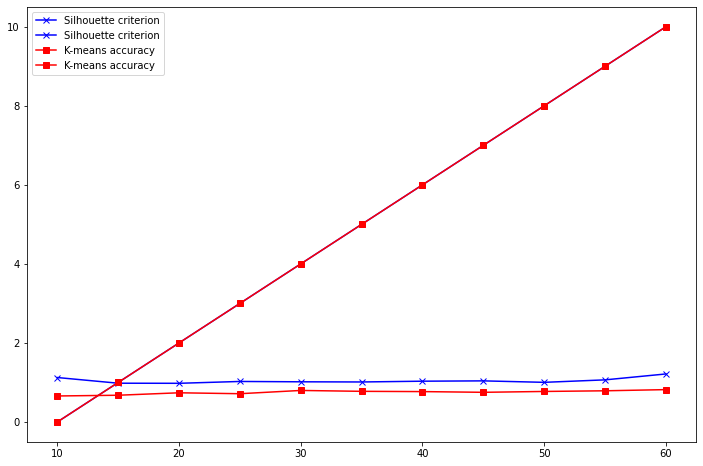

In [ ]:
list_of_cluster_numbers=[10,15,20,25,30,35,40,45,50,55,60]


plt.figure(figsize=(12, 8))
plt.plot(list_of_cluster_numbers, normalised_silhouette_scores, c='b', marker='x', label='Silhouette criterion')
plt.plot(list_of_cluster_numbers, k_means_accuracies, c='r', marker='s', label='K-means accuracy')
plt.legend(loc='upper left')
plt.show()